<h1 style="text-align: center; vertical-align: middle;">Numerical Methods in Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Python examples -- Week 9</h2>

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config9 import (np, plt, radon, iradon, Image, 
                    tnrange, plot_mp, plot_tomo)
from scipy.constants import m_p, e, c
%matplotlib inline

<h2>Projection integral: Radon transform</h2>

Load sample image for the tomography:

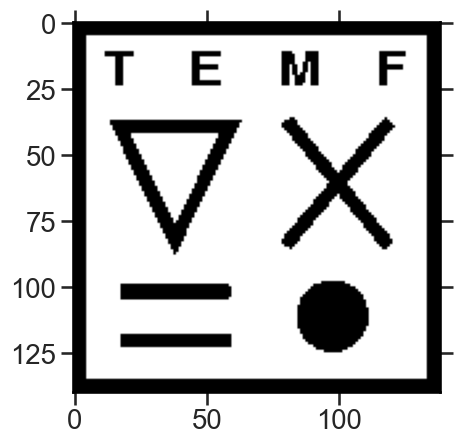

In [2]:
data = ~np.array(Image.open('src/temf.png').convert('1', dither=False))

plt.imshow(data, cmap='binary');

Compute the Radon transform at an angle of 0 deg and 90 deg:

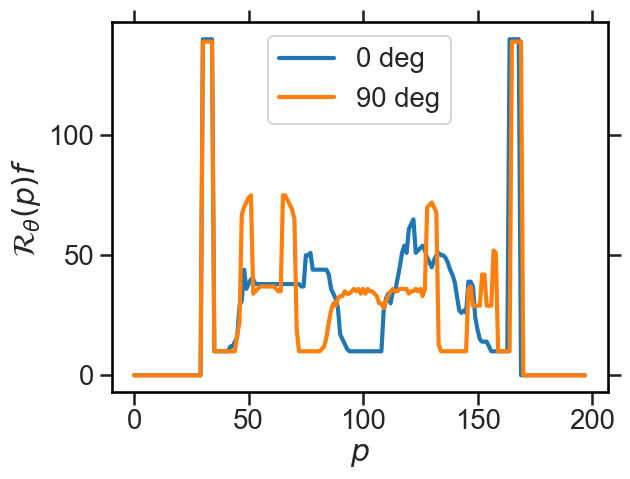

In [3]:
Rf_0 = radon(data, [0], circle=False).astype(float)
Rf_90 = radon(data, [90], circle=False).astype(float)

plt.plot(Rf_0, label='0 deg')
plt.plot(Rf_90, label='90 deg')
plt.legend()
plt.xlabel('$p$')
plt.ylabel(r'$\mathcal{R}_{\theta}(p)f$');

<h3>Preparing the measurement data</h3>

We take a number of `VIEW` measurements across the angular interval of [0,`ANG`] degrees:

In [4]:
# parameters
M = max(data.shape)
ANG = 180
VIEW = 180
THETA = np.linspace(0, ANG, VIEW, endpoint=False)

`A` is the projection operator, applying the Radon transform along all chosen angles `THETA` to the original object under study, $x$ (`data`):

In [5]:
A = lambda x: radon(x, THETA, circle=False).astype(float)

In [6]:
proj = A(data)

<h3>Sinogram</h3>

The sinogram represents the measurement, the collection of all projection results:

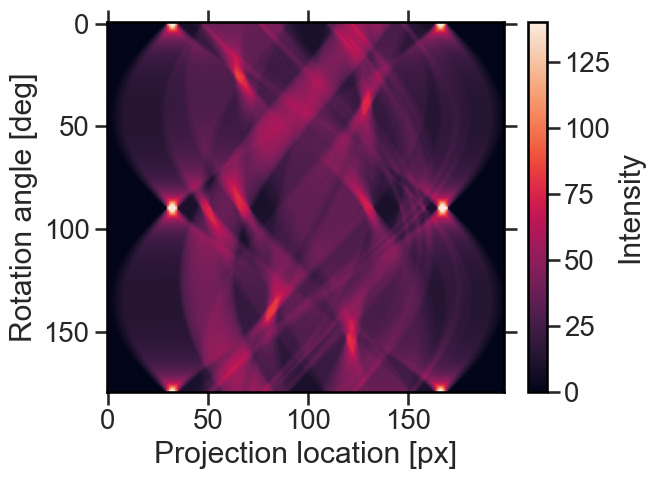

In [7]:
plt.imshow(proj.T)

plt.gca().set_aspect('auto')
plt.xlabel('Projection location [px]')
plt.ylabel('Rotation angle [deg]')
plt.colorbar(label='Intensity');

<h2>Using Filtered Back Projection</h2>

Let's apply the back projection as an inverse Radon transform (implemented with a ramp filter):

In [8]:
AINV = lambda b: iradon(b, THETA, circle=False, filter_name='ramp', output_size=M).astype(float)

In [9]:
fbp = AINV(proj)

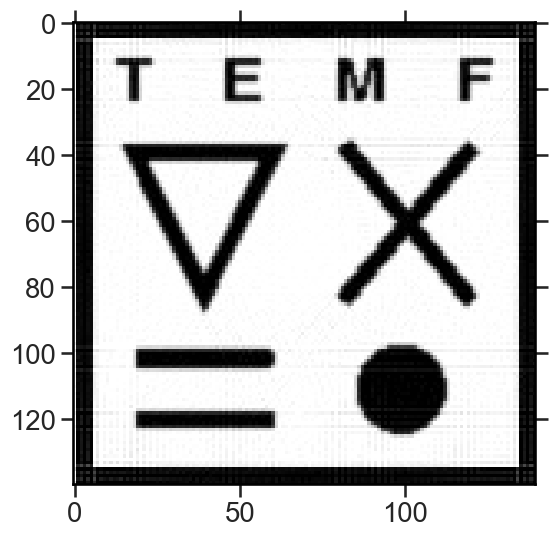

In [10]:
plt.figure(figsize=(12, 6))
plt.imshow(fbp, cmap='binary', vmin=0, vmax=1);

$\implies$ note the artifacts due to edges in the reconstructed image (high frequency!).

<h2>Effect of Noise</h2>

In the following, we will compare the FBP with the iterative ART approach on a noisy sinogram.

We add 15% of the maximum sinogram value as Gaussian normal distributed noise:

In [11]:
noise = np.random.normal(0, 0.15 * np.max(proj), size=proj.shape)

In [12]:
proj_noise = proj + noise

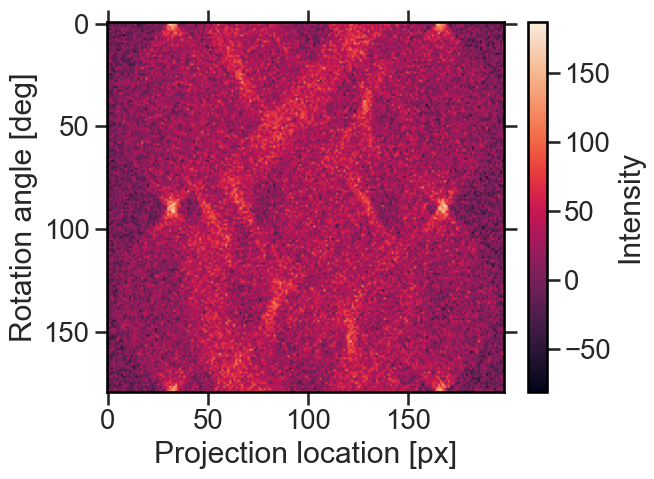

In [13]:
plt.imshow(proj_noise.T)
plt.gca().set_aspect('auto')
plt.xlabel('Projection location [px]')
plt.ylabel('Rotation angle [deg]')
plt.colorbar(label='Intensity');

<h3>Filtered Back Projection Results</h3>

In [14]:
fbp_noise = AINV(proj_noise)

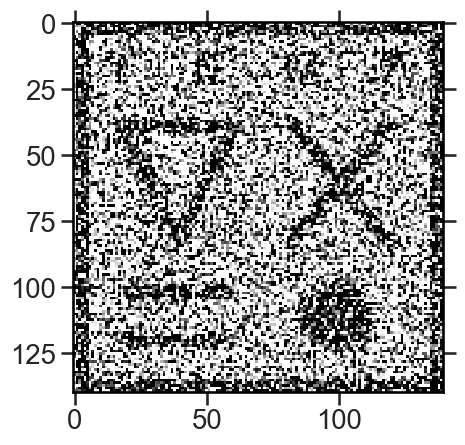

In [15]:
plt.imshow(fbp_noise, cmap='binary', vmin=0, vmax=1, interpolation='None');

<h3>Implement the Algebraic Reconstruction Technique</h3>

Besides the projection operator $A$ (`A`), we need the adjoint $A^\mathrm{T}$ (`AT`) for the ART implementation:

In [16]:
AT = lambda b: iradon(b, THETA, circle=False, filter_name=None, output_size=M).astype(float) * 2 * len(THETA) / np.pi

In [17]:
def ART(A, AT, b, x, mu=1, niter=10):
    # for all i: ||a_i||^2 = A^T ⋅ A
    ATA = AT(A(np.ones_like(x)))

    for i in tnrange(niter):
        x = x + np.divide(mu * AT(b - A(x)), ATA)

        # nonlinearity: constrain to >= 0 values
        x[x < 0] = 0

        plt.imshow(x, cmap='binary', vmin=0, vmax=1, interpolation='None')
        plt.title("%d / %d" % (i + 1, niter))
        plt.show()

    return x

# initialization
x0 = np.zeros((M, M))
mu = 1
niter = 100

<h3>ART Results</h3>

  0%|          | 0/100 [00:00<?, ?it/s]

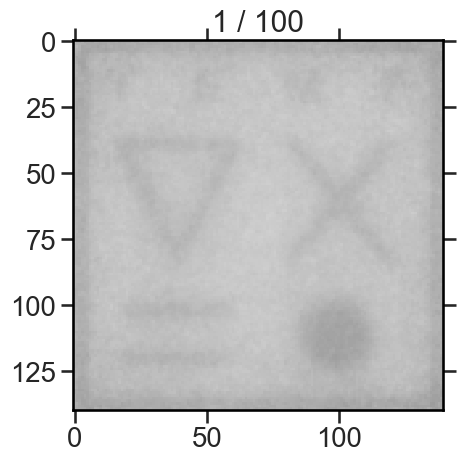

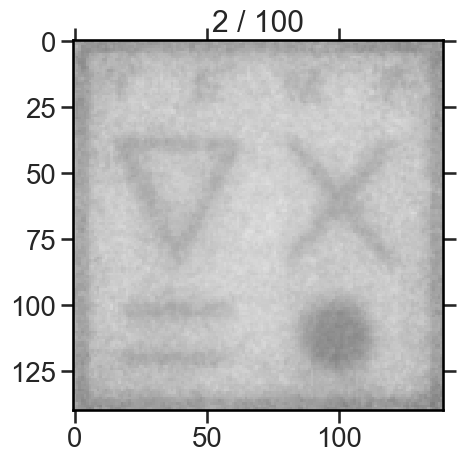

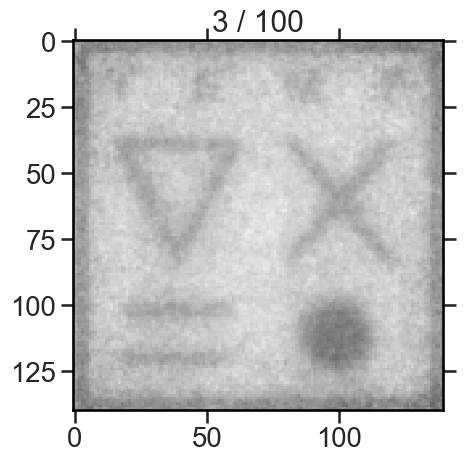

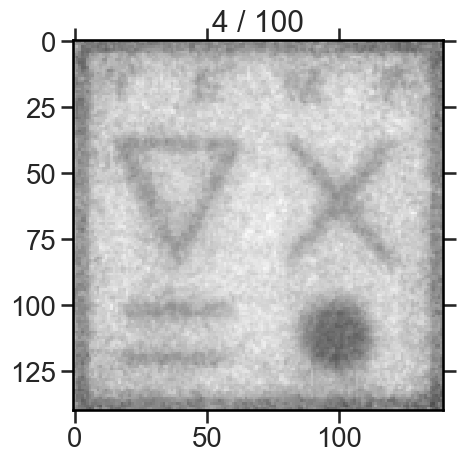

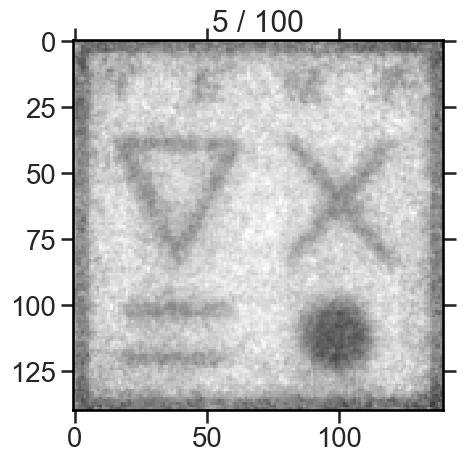

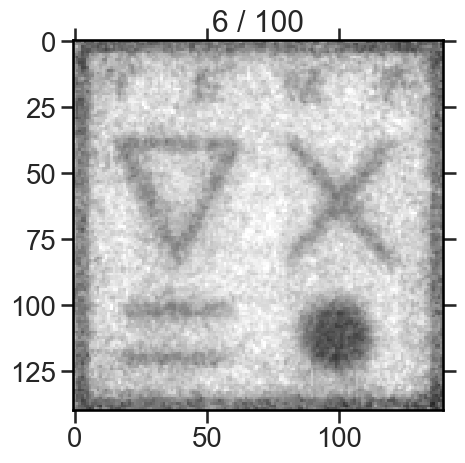

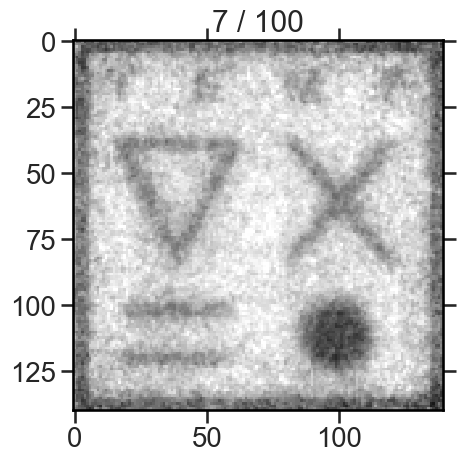

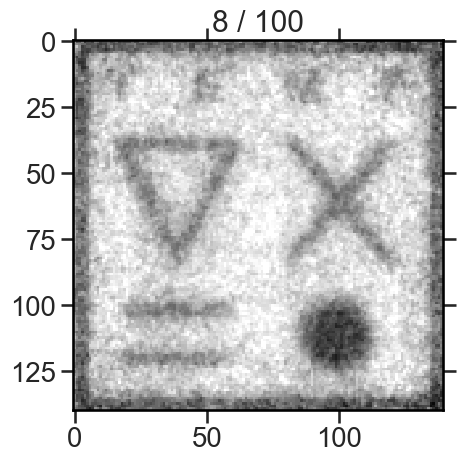

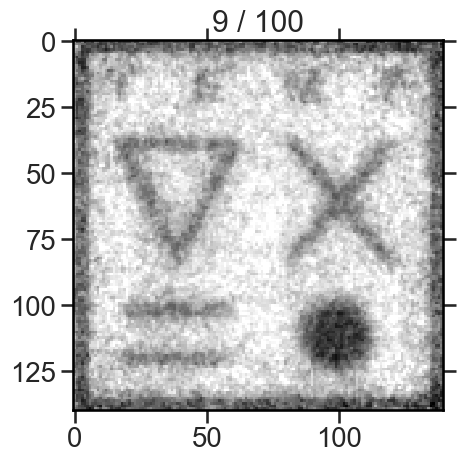

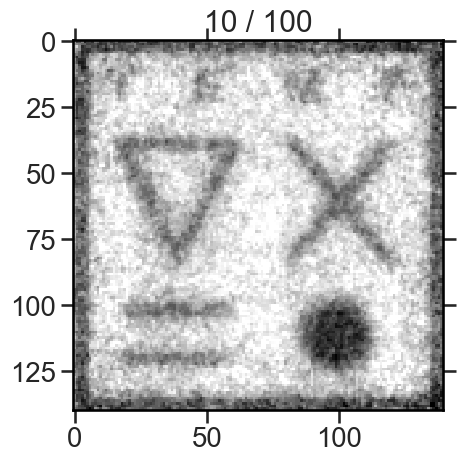

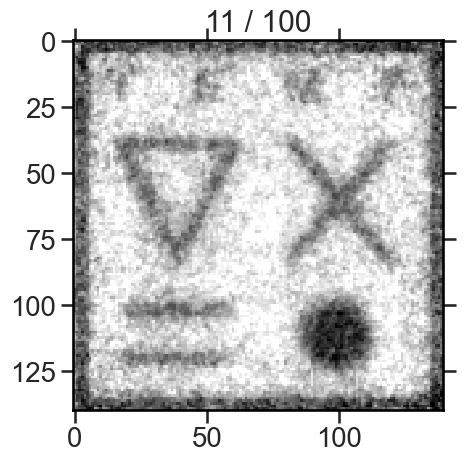

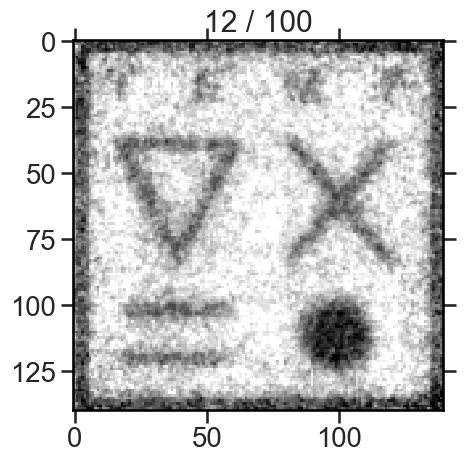

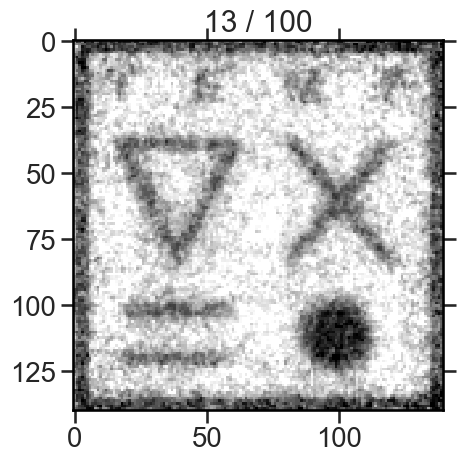

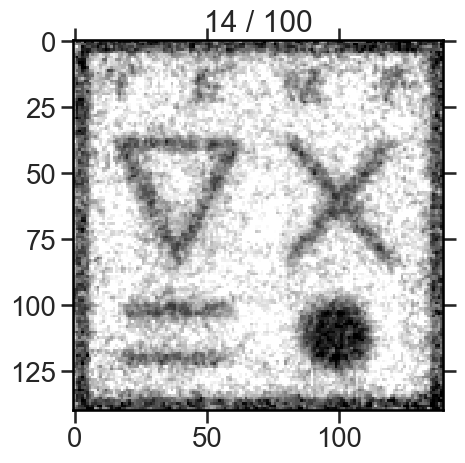

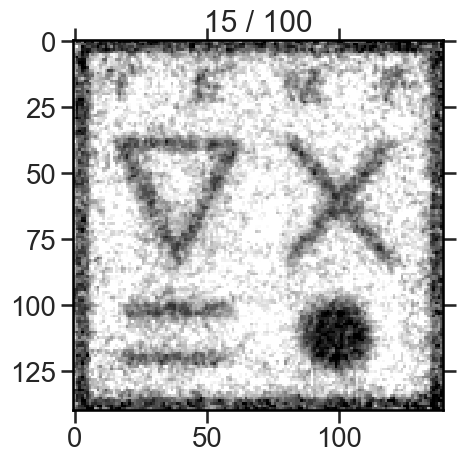

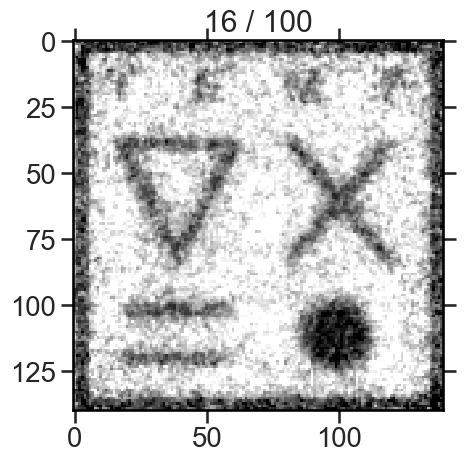

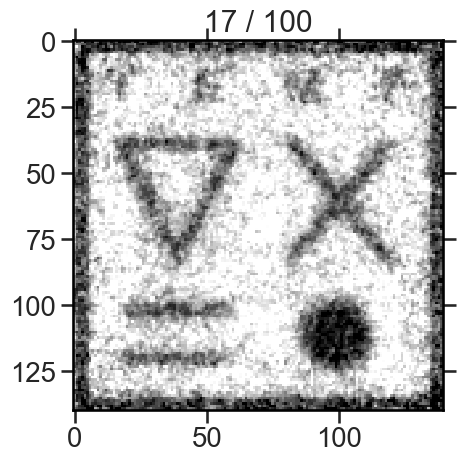

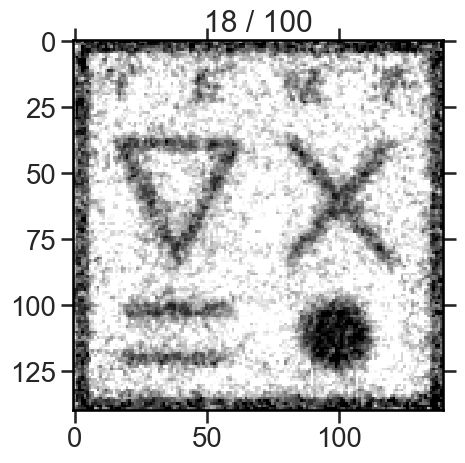

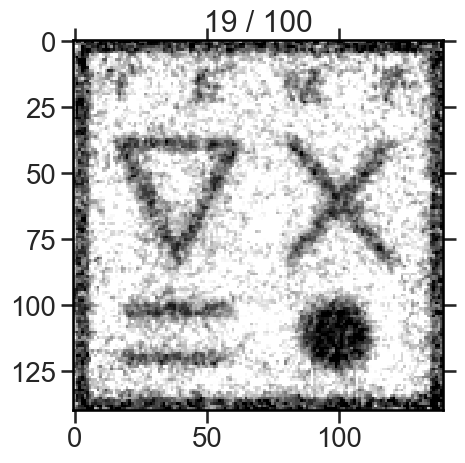

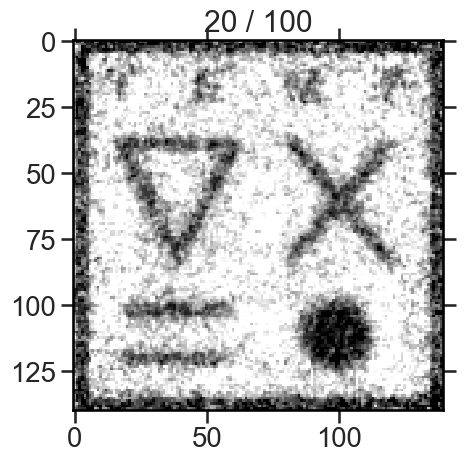

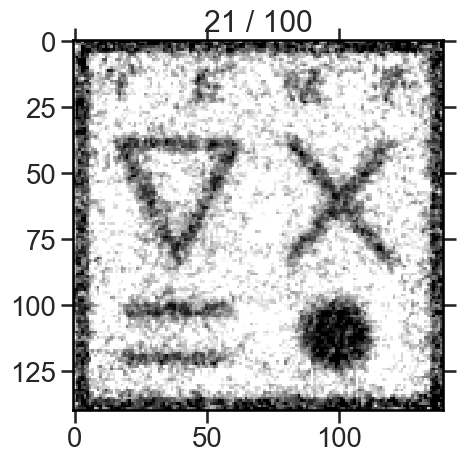

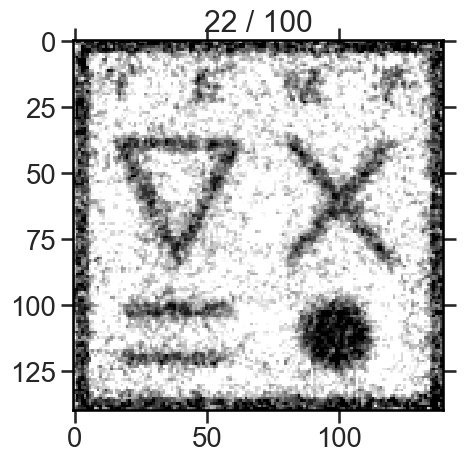

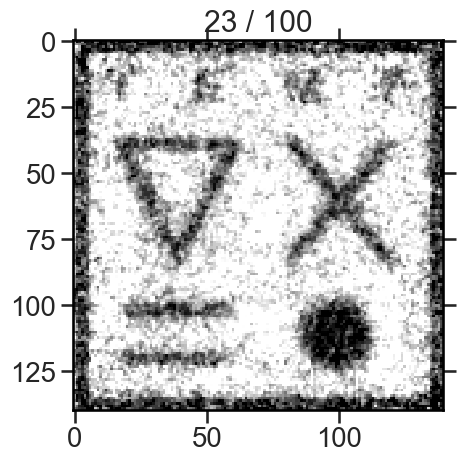

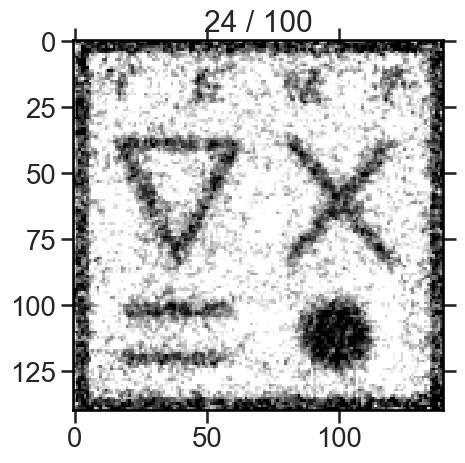

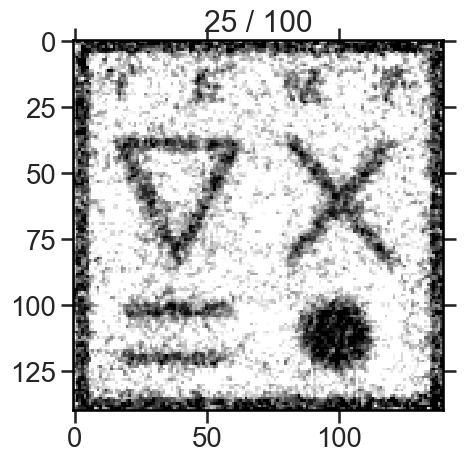

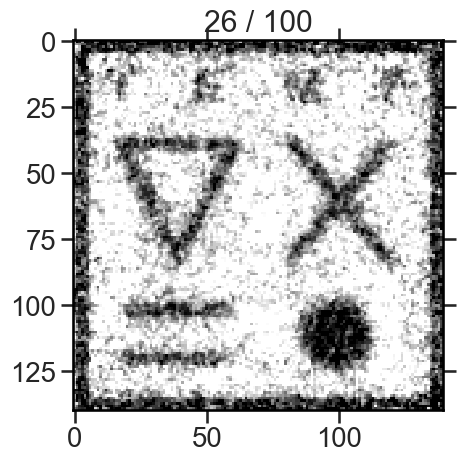

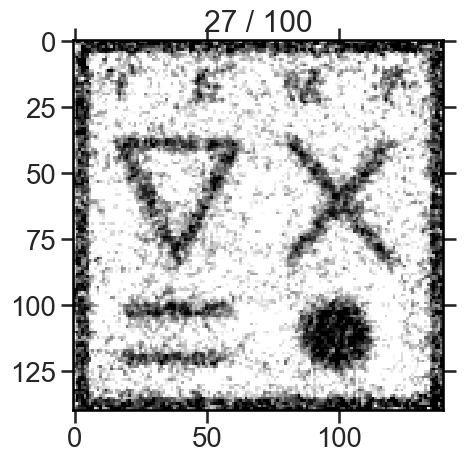

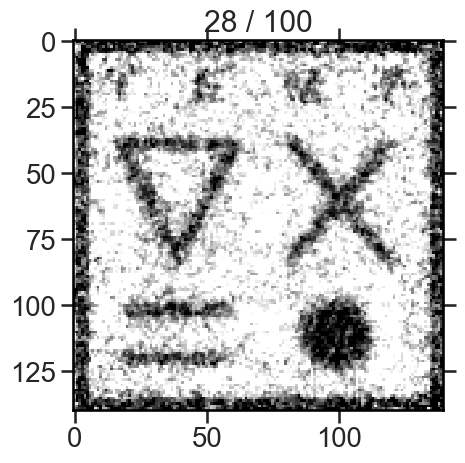

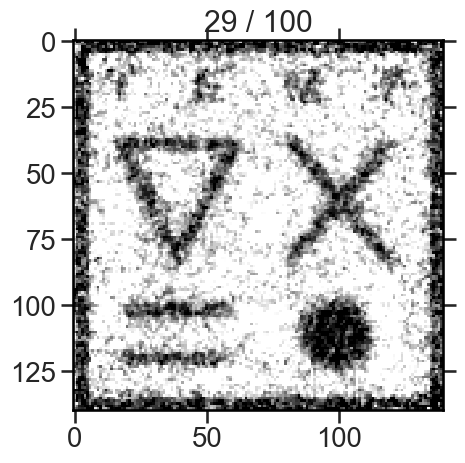

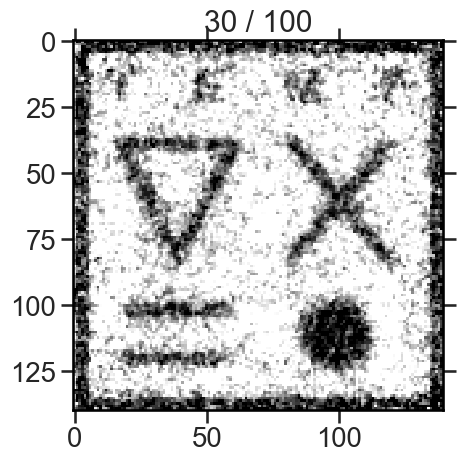

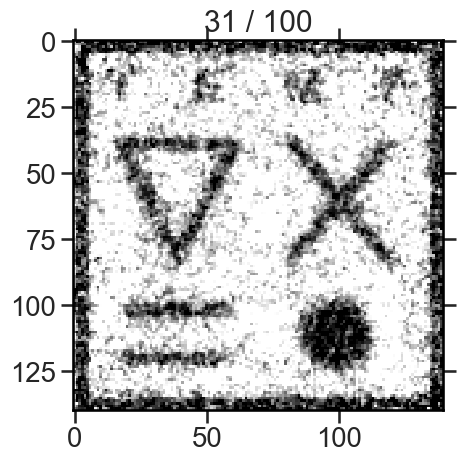

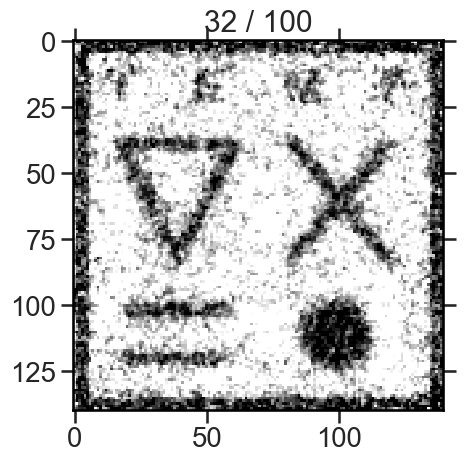

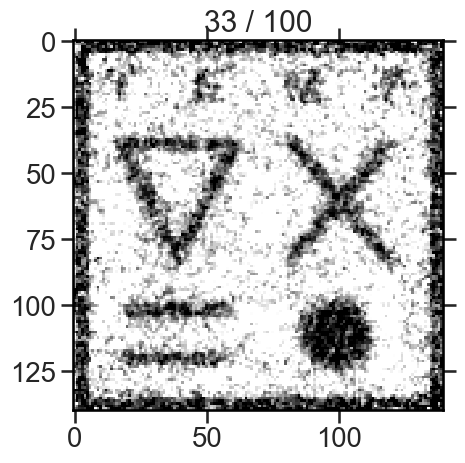

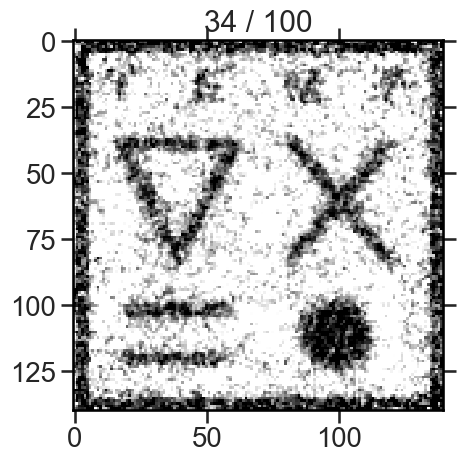

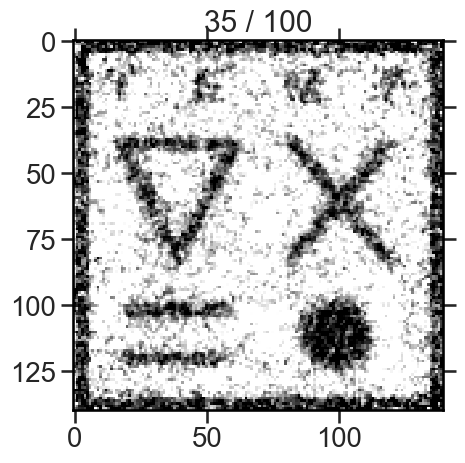

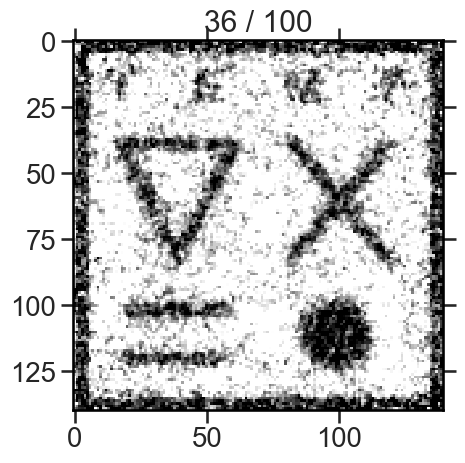

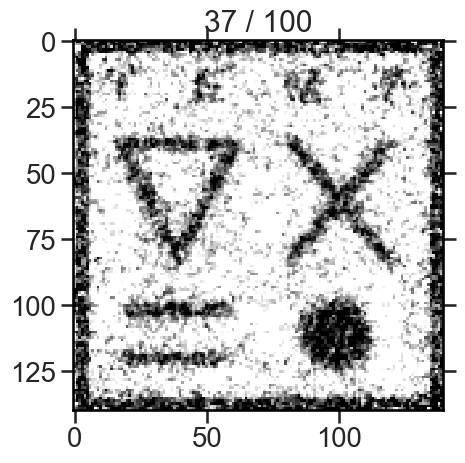

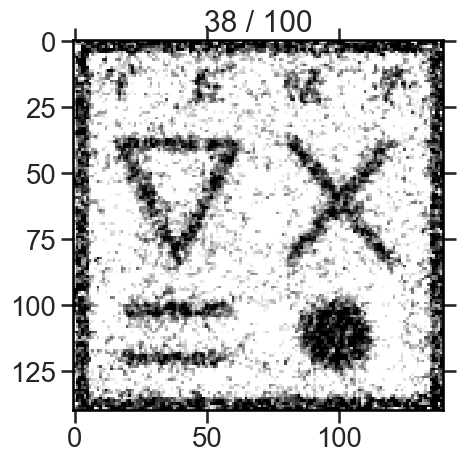

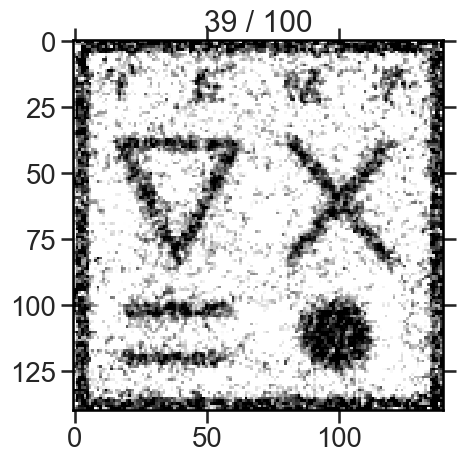

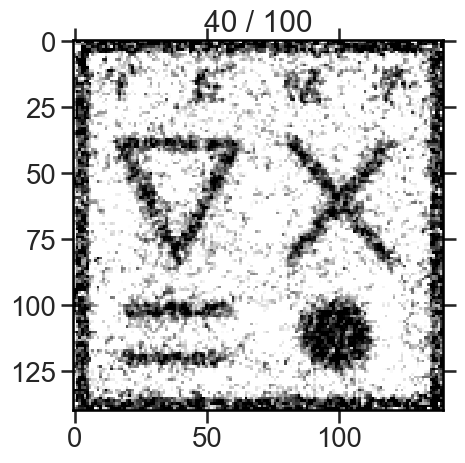

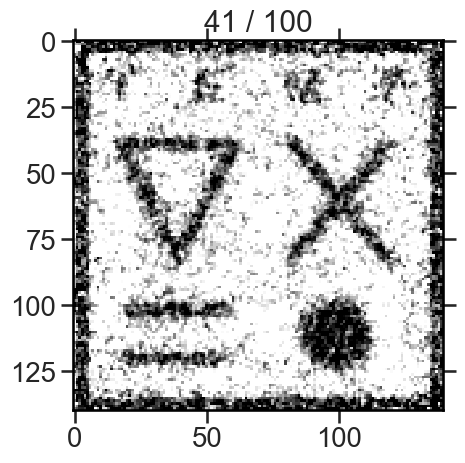

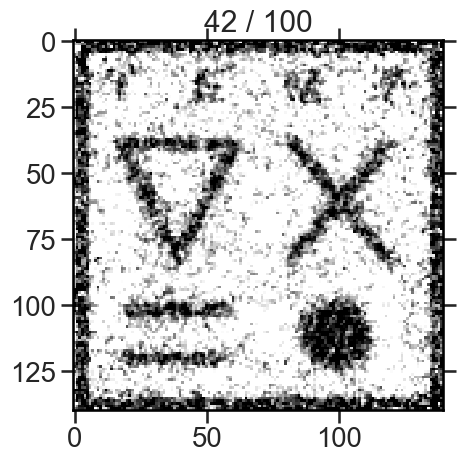

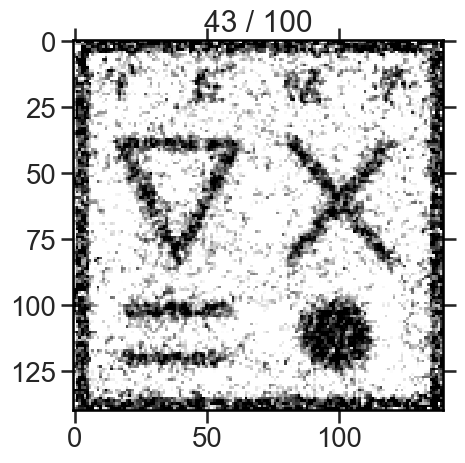

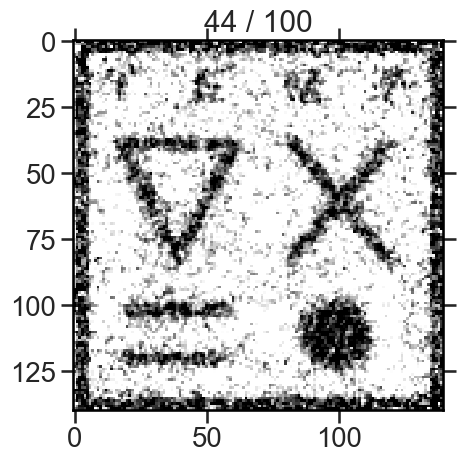

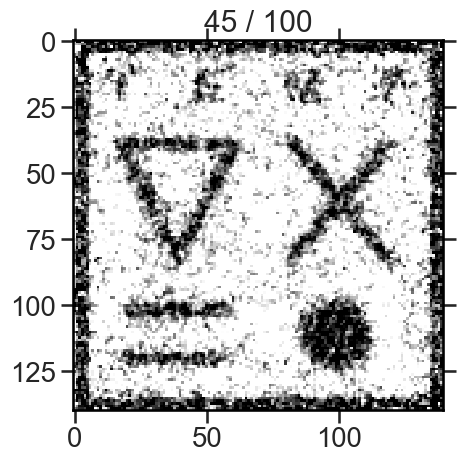

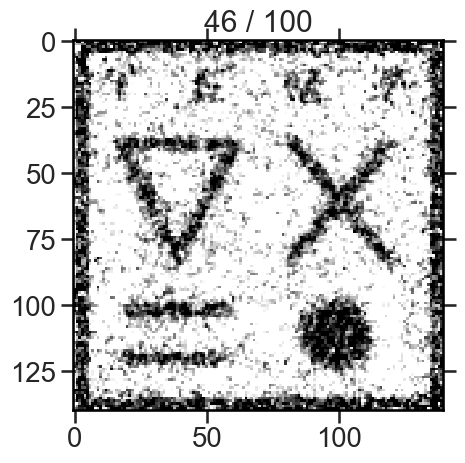

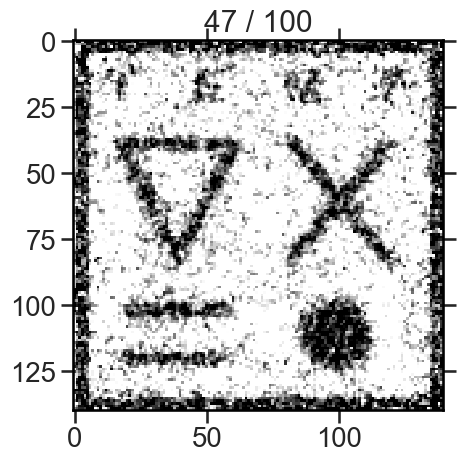

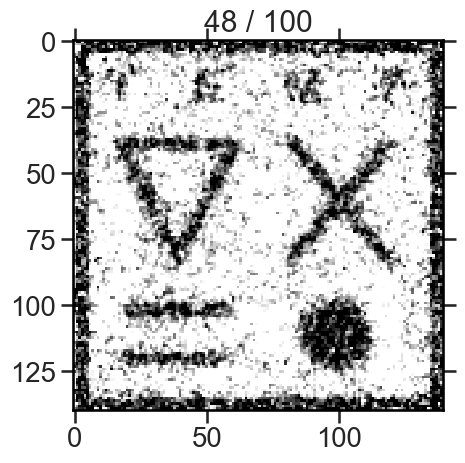

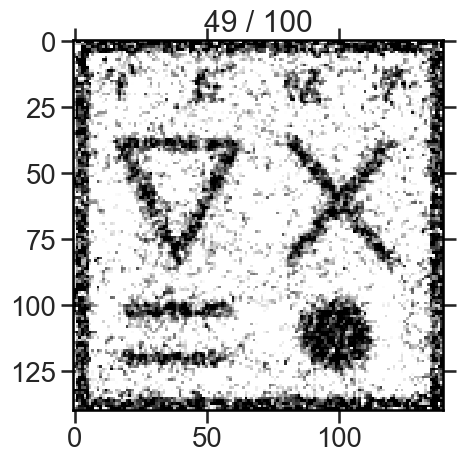

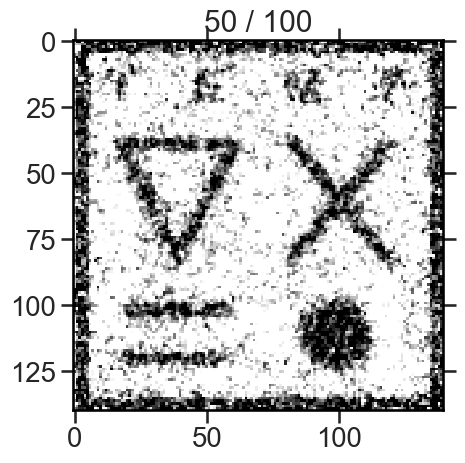

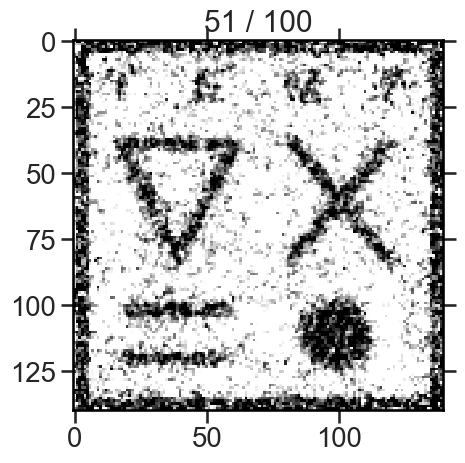

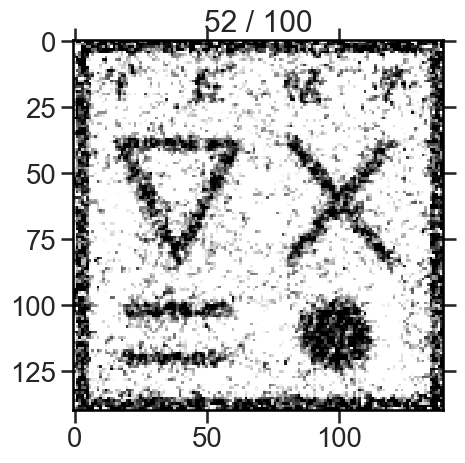

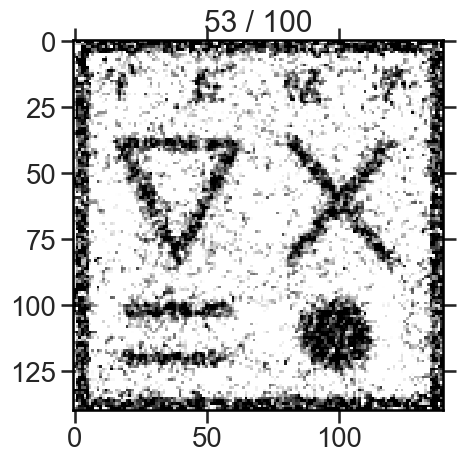

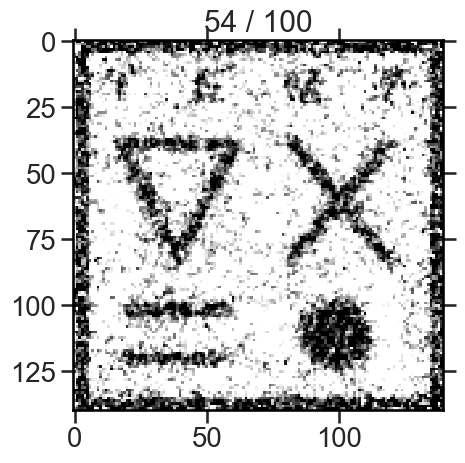

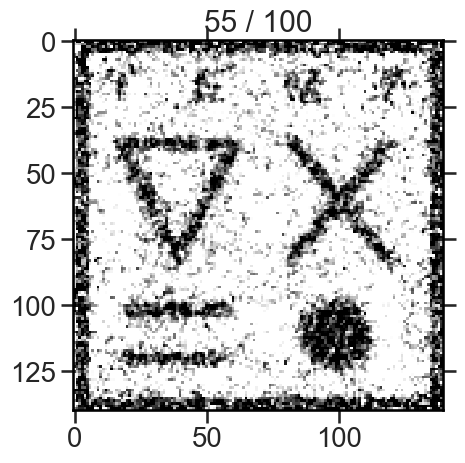

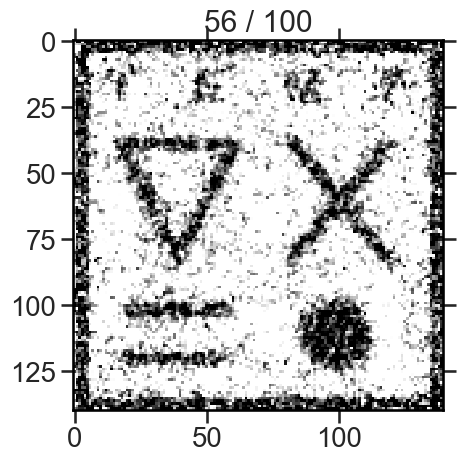

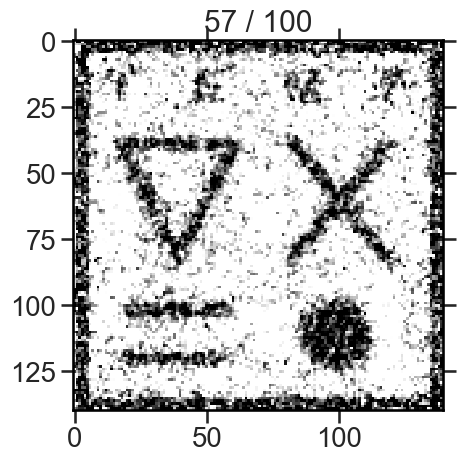

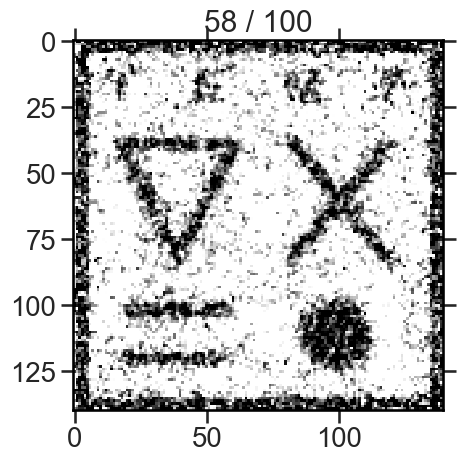

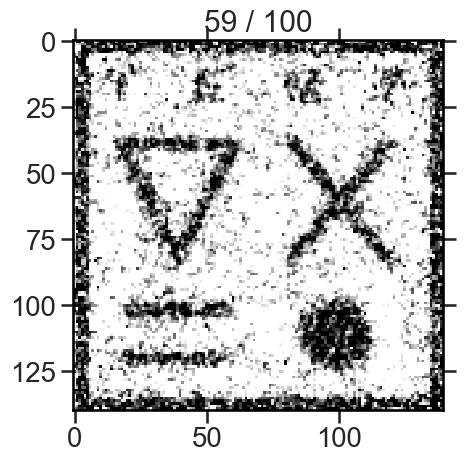

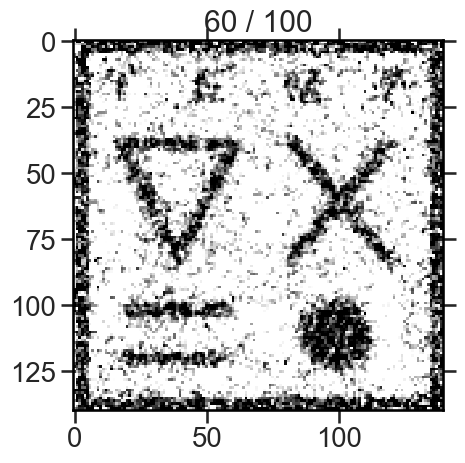

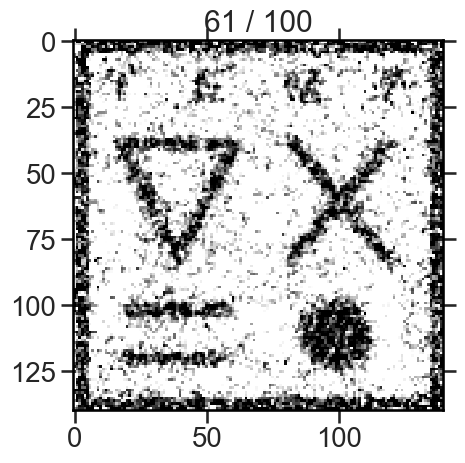

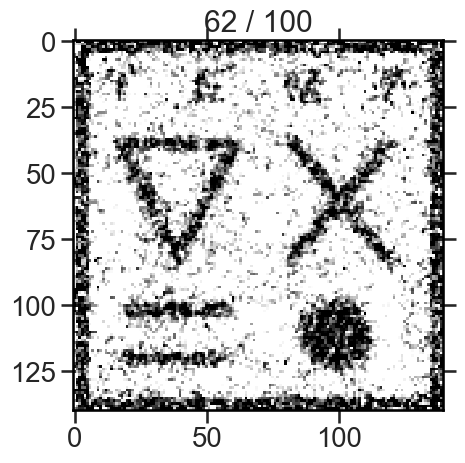

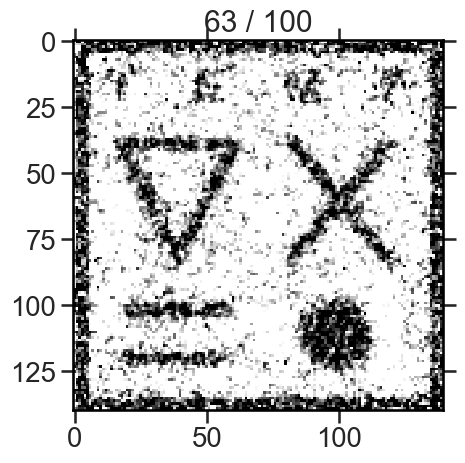

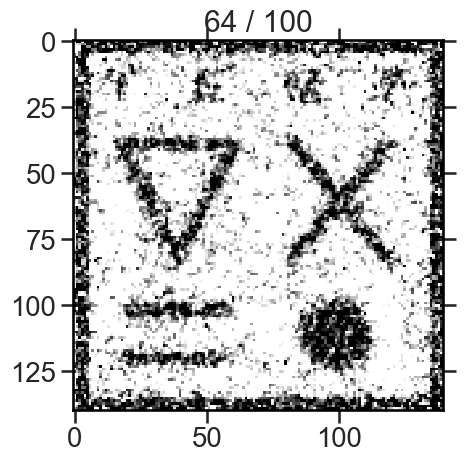

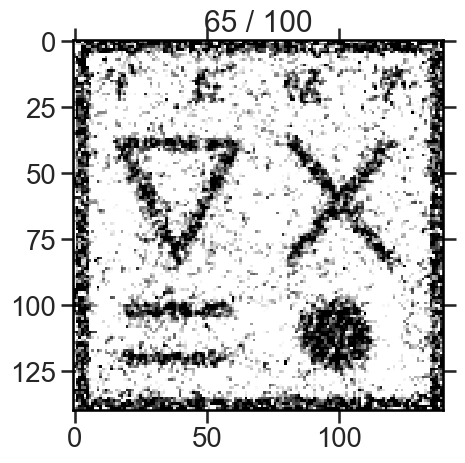

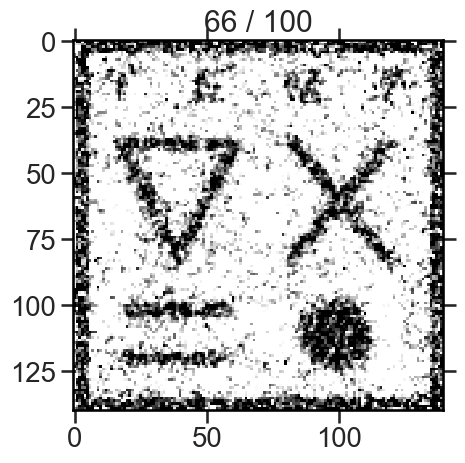

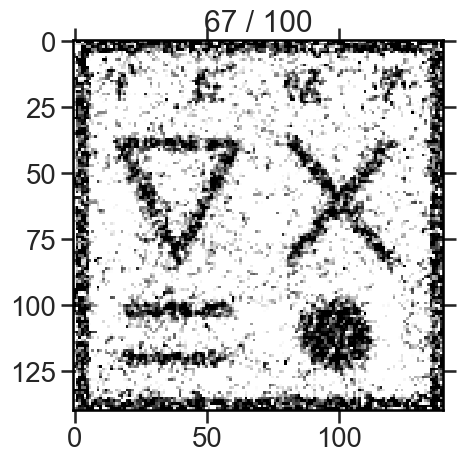

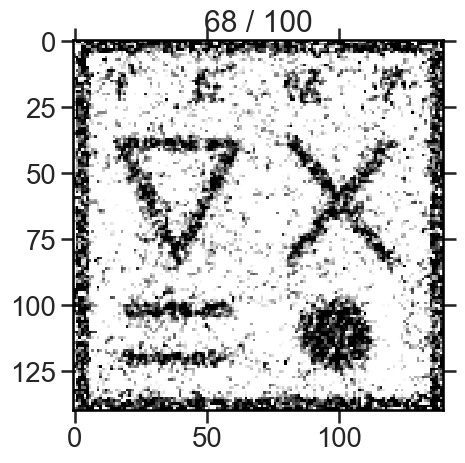

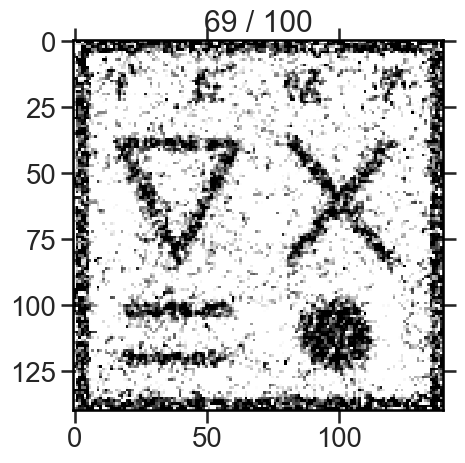

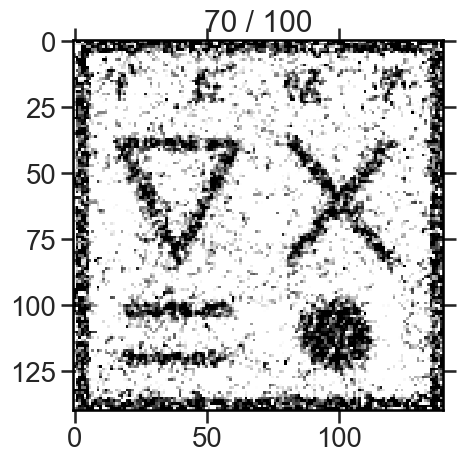

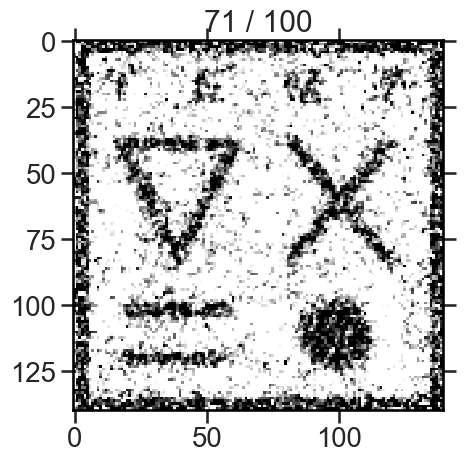

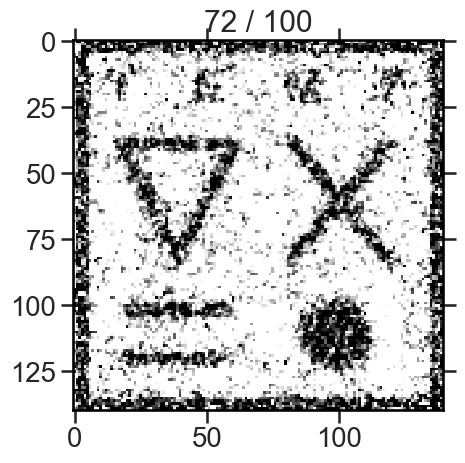

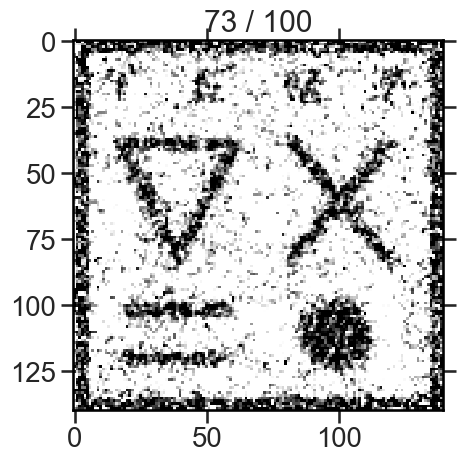

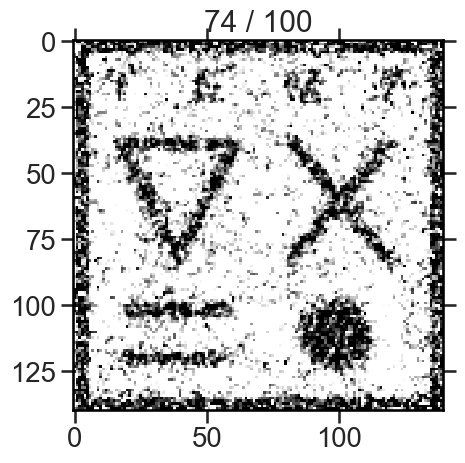

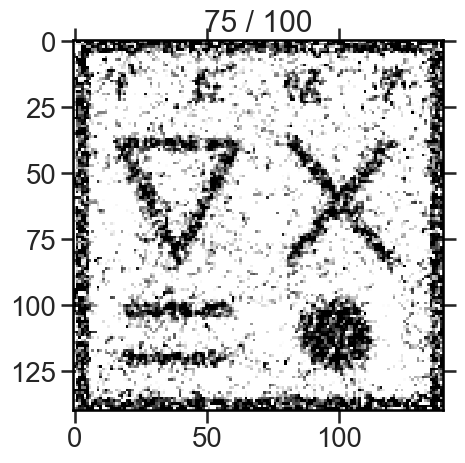

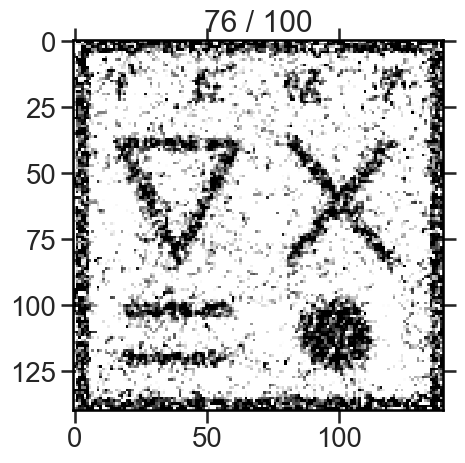

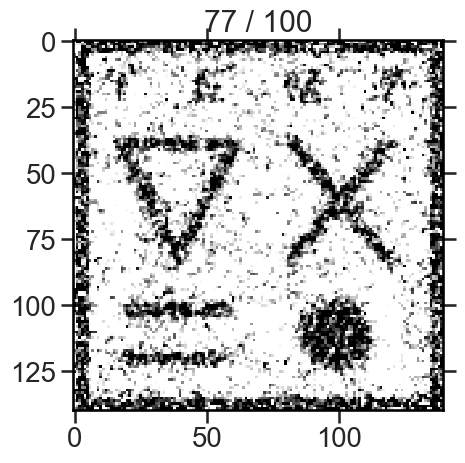

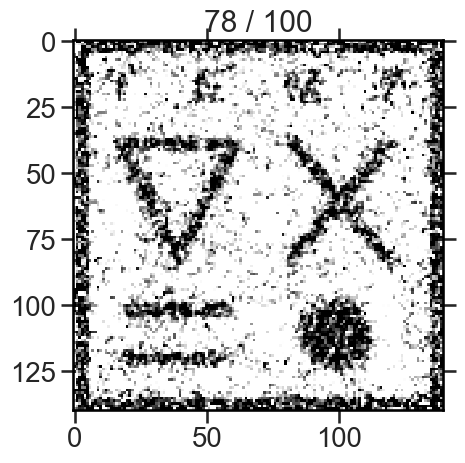

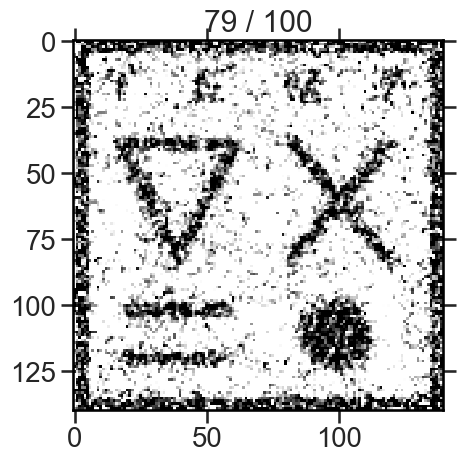

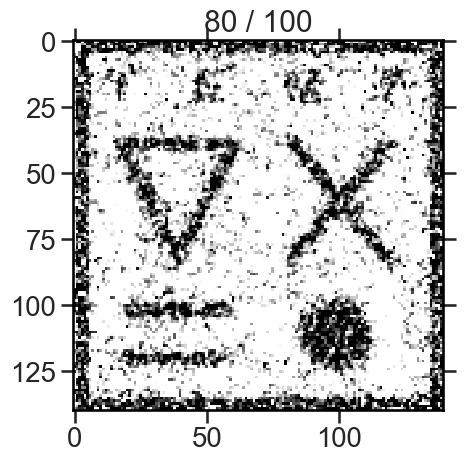

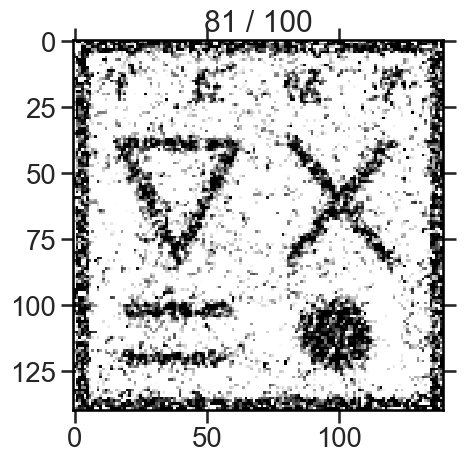

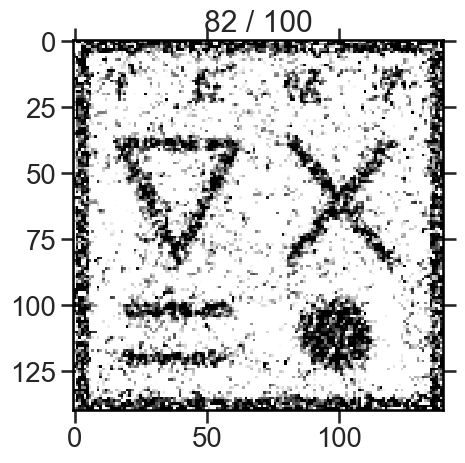

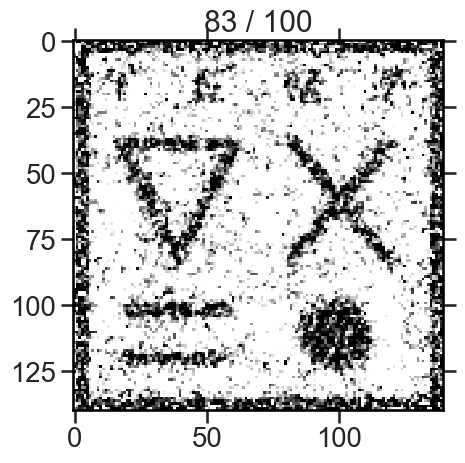

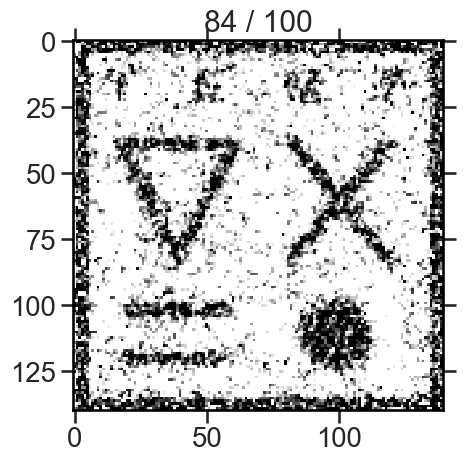

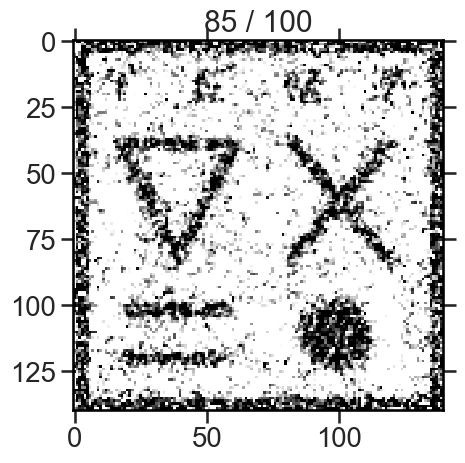

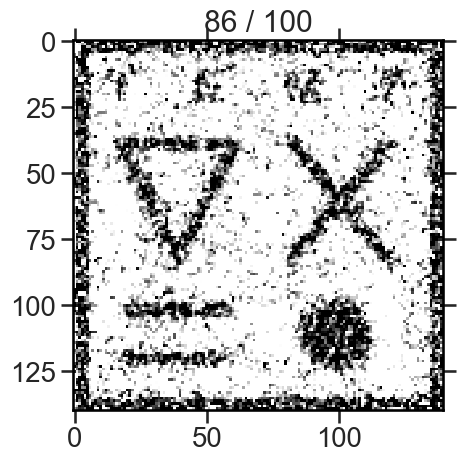

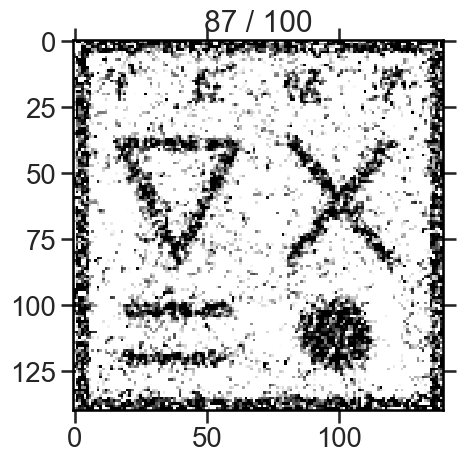

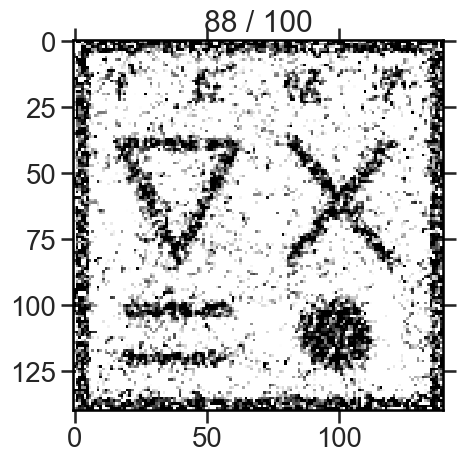

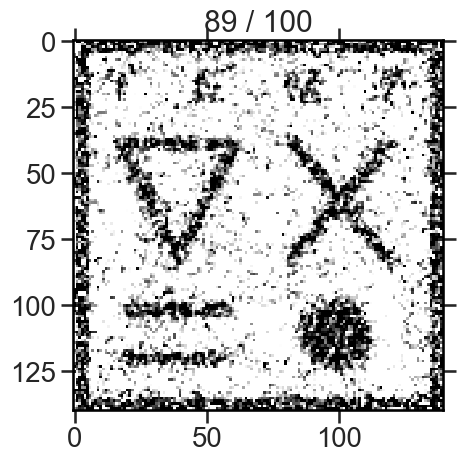

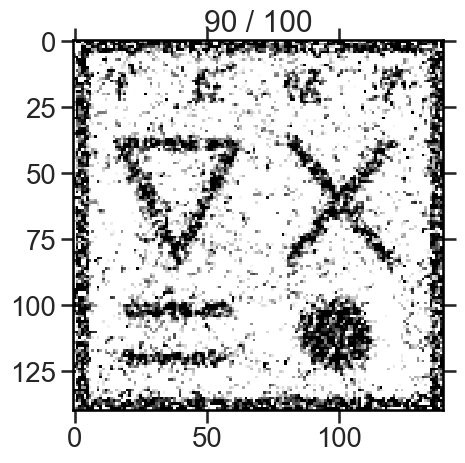

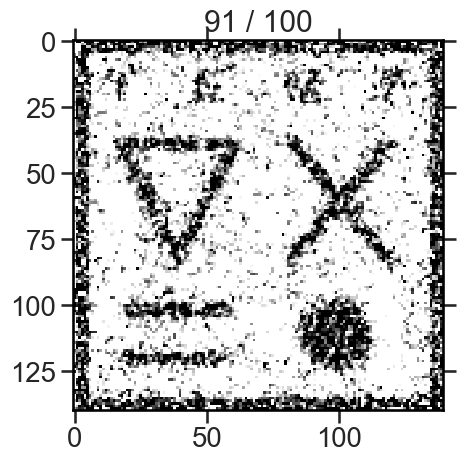

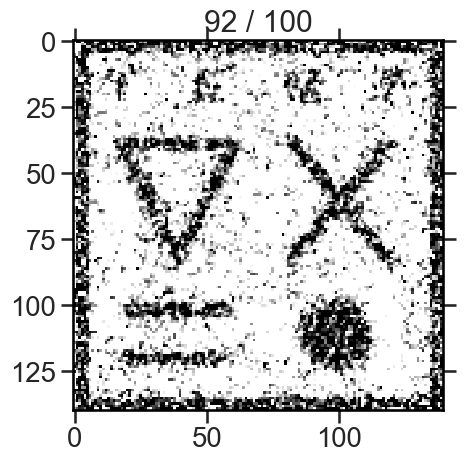

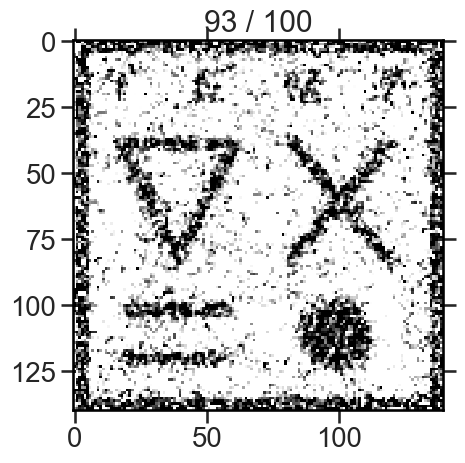

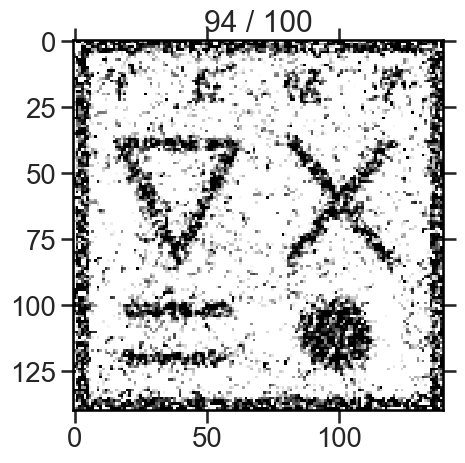

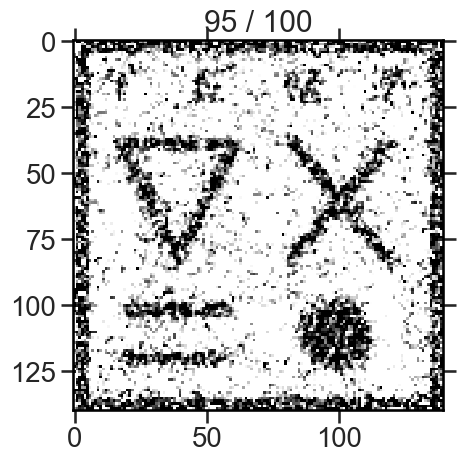

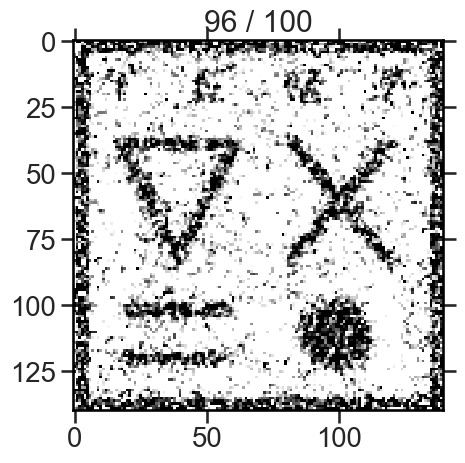

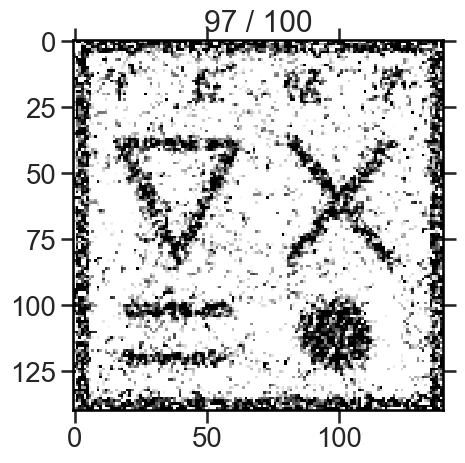

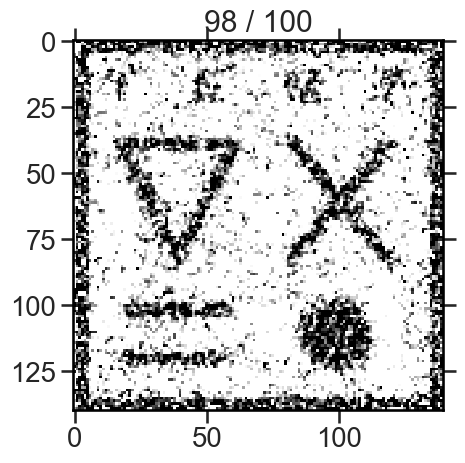

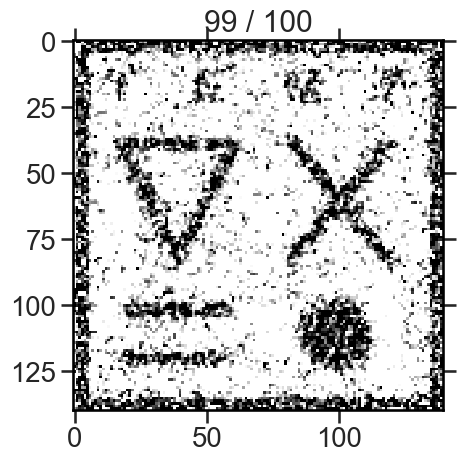

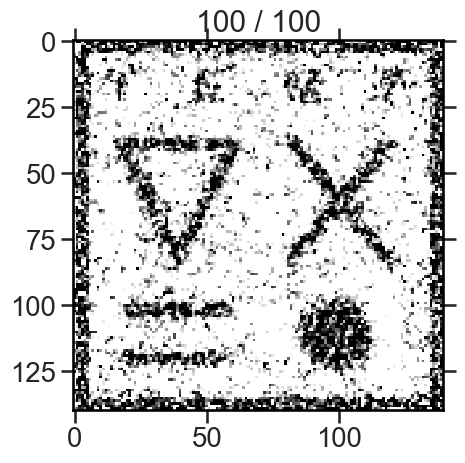

In [18]:
x_art = ART(A, AT, proj_noise, x0, mu, niter)

<h3>Comparison of the Results</h3>

ART typically outperforms FBP in terms of reconstruction quality:

Text(0.5, 1.0, 'ART')

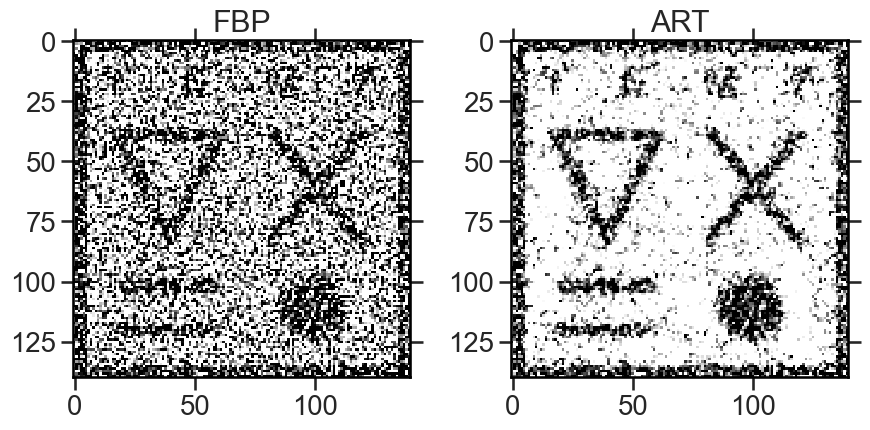

In [19]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.3)

plt.sca(ax[0])
plt.imshow(fbp_noise, cmap='binary', vmin=0, vmax=1, interpolation='None')
plt.title('FBP')

plt.sca(ax[1])
plt.imshow(x_art, cmap='binary', vmin=0, vmax=1, interpolation='None')
plt.title('ART')

<h2>Phase-space Tomography</h2>

The `longitudinal_tomograpy` package is developed at CERN: control room apps tomographically reconstruct the longitudinal phase-space distribution from bunch profile measurements!

In [20]:
import longitudinal_tomography.tomography.tomography as tmo
from longitudinal_tomography.tracking import particles, machine

import longitudinal_tomography.utils.tomo_input as tomoin
import longitudinal_tomography.utils.tomo_output as tomoout
from longitudinal_tomography.tracking import tracking

We work once more with the `PyHEADTAIL` library to generate the longitudinal macro-particle distribution.

If `PyHEADTAIL` is not installed, please run this:

In [21]:
#!pip install PyHEADTAIL==1.16.4

In [22]:
from PyHEADTAIL.particles.generators import RFBucketMatcher, ThermalDistribution
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.16.5


<h3>Beam Measurements</h3>

Consider a circulating bunch in a synchrotron or storage ring. Longitudinal bunch profiles can be recorded via wall current monitor with a high-bandwidth oscilloscope: store $V_\mathrm{gap}(t)$ during the bunch passage time $t$.

<h3>Physical Beam Parameters</h3>

During previous lectures we discussed reduced models for the longitudinal plane. We have
- `voltage`: rf voltage
- `harmonic`: rf frequency divided by revolution frequency
- `circumference`: accelerator ring circumference
- `gamma`: Lorentz gamma of bunch
- `alpha_c`: momentum compaction of the ring

In [23]:
voltage = 24e3
harmonic = 7
circumference = 100 * 2 * np.pi

gamma = 3.1
beta = np.sqrt(1 - gamma**-2)

alpha_c = 0.027
eta = alpha_c - gamma**-2

We look at a circuating proton bunch in a CERN Proton Synchrotron like machine. A "full bunch length" of $B_L = 180$ns translates to an rms bunch length in meters of $\sigma_z=B_L/4\cdot\beta c$. As before, the following `PyHEADTAIL` `RFBucket` class captures most of the important quantities for computation.

In [24]:
rfb = RFBucket(circumference, gamma, m_p, e, [alpha_c], 0., [harmonic], [voltage], [np.pi])

sigma_z = 180e-9 * beta * c / 4. # in [m]

<h3> A. The simulated measurement</h3>
<h4>Initialisation of particles</h4>

A thermal distribution of $N$ particles is matched into the rf bucket.

In [25]:
N = 100000

In [26]:
np.random.seed(12345)

rfb_matcher = RFBucketMatcher(rfb, ThermalDistribution, sigma_z=sigma_z)
rfb_matcher.integrationmethod = 'cumtrapz'

z, dp, _, _ = rfb_matcher.generate(N)

*** Maximum RMS bunch length 14.146533693849058m.
... distance to target bunch length: -1.2642e+01
... distance to target bunch length: 9.8693e-01
... distance to target bunch length: 9.2123e-01
... distance to target bunch length: -6.1412e-01
... distance to target bunch length: 4.1253e-01
... distance to target bunch length: 1.2473e-01
... distance to target bunch length: -1.1252e-02
... distance to target bunch length: 8.1693e-04
... distance to target bunch length: 4.9433e-06
... distance to target bunch length: -1.0032e-05
--> Bunch length: 12.769481601844385
--> Emittance: 1.8021366072066731


In case `PyHEADTAIL` is not available, import the generated distribution directly (uncomment one of the following lines):

In [27]:
# z, dp = np.load('data/long-dist-80ns.npy') # short bunch
# z, dp = np.load('data/long-dist-180ns.npy') # long bunch

The distribution in longitudinal phase space ($z$, $\delta$) looks as follows:

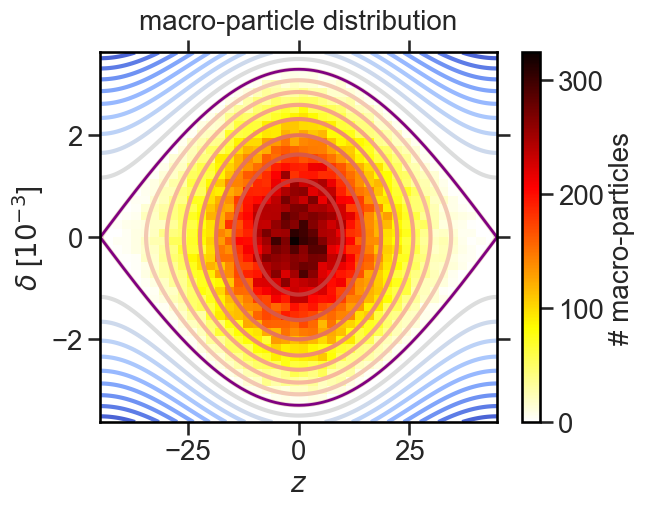

In [28]:
plot_mp(z, dp, rfb);

Let's have a look at the bunch profile as it would appear in a discrete measurement (e.g. via a wall current monitor).

In [29]:
nbins = 100
z_bins = np.linspace(*rfb.interval, num=nbins-1)

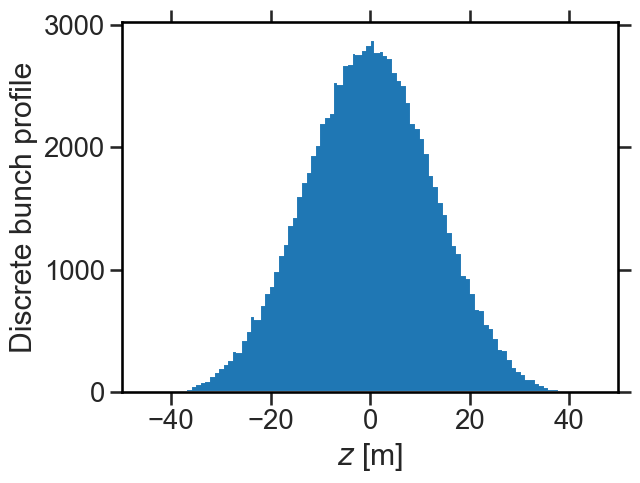

In [30]:
plt.hist(z, bins=z_bins, histtype='stepfilled')
plt.xlabel('$z$ [m]')
plt.ylabel('Discrete bunch profile');

A single bin of the profile measurement amounts to a time (in seconds) of

In [31]:
dtbin = (z_bins[1] - z_bins[0]) / (beta * c)
dtbin

3.259992054798442e-09

The synchrotron period `T_s`, i.e. the time period of the longitudinal motion, amounts to the following number of turns:

In [32]:
T_s = int(1 / rfb.Q_s)
T_s

1124

<h4>Deliberate mismatch</h4>

To provide some interesting dynamics for the tomographic reconstruction, let's mismatch the distribution in momentum. This will launch a quadrupolar oscillation, i.e. the bunch length and momentum spread will oscillate during the synchrotron period.

In [33]:
dp *= 0.3

As one can see, the distribution does not follow the iso-Hamiltonian lines (red) any longer but is slightly compressed along the momentum $\delta$ axis:

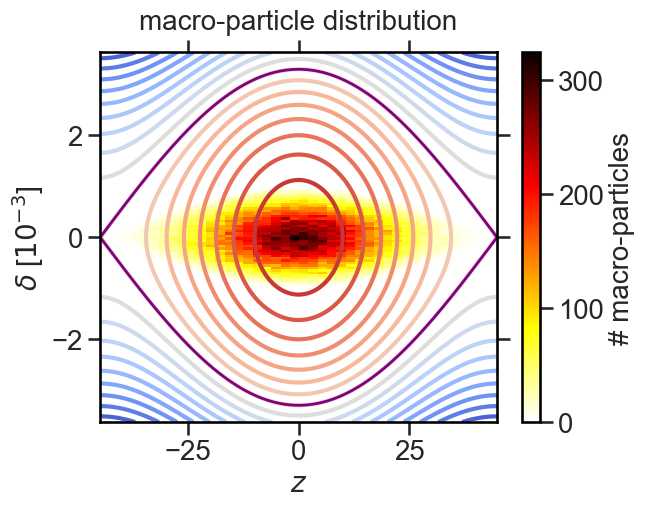

In [34]:
plot_mp(z, dp, rfb);

<h4>Particle Tracking</h4>

We model the synchrotron motion of the particles due to the rf cavities once more via a second order leap-frog integrator. The `track` function advances the particles by one turn:

In [35]:
def track(z, dp, rfb=rfb):
    # half drift
    z = z - eta * dp * circumference / 2
    # rf kick
    amplitude = rfb.charge * voltage / (beta * c * rfb.p0)
    phi = harmonic * (2 * np.pi * z / circumference) + rfb.phi_offset_list[0]
    dp += amplitude * np.sin(phi)
    # half drift
    z = z - eta * dp * circumference / 2
    return z, dp

Let's gather the data for the tomographic reconstruction by recording a bunch profile every few turns during one `T_s`:

In [36]:
record_every_nturns = 10

In [37]:
raw_data = [np.histogram(z, bins=z_bins)[0]]

for i in tnrange(1, T_s + 1):
    z, dp = track(z, dp)
    if not i % record_every_nturns:
        # the discrete WCW measurement:
        raw_data += [np.histogram(z, bins=z_bins)[0]]

  0%|          | 0/1124 [00:00<?, ?it/s]

The quadrupole oscillation is clearly visible:

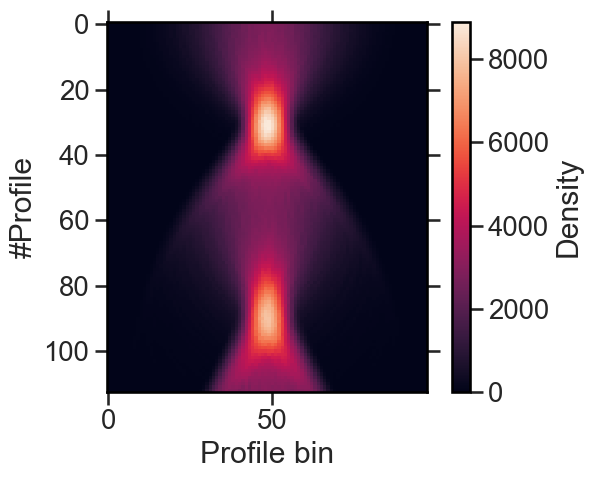

In [38]:
plt.imshow(raw_data)
plt.xlabel('Profile bin')
plt.ylabel('#Profile')
plt.colorbar(label='Density');

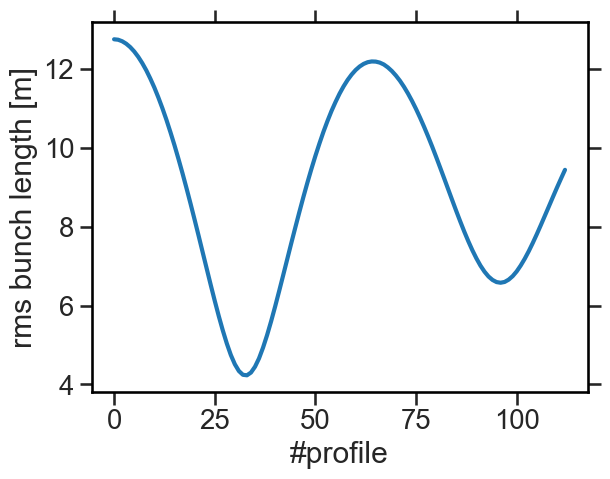

In [39]:
std=[np.sqrt(np.average((np.array((z_bins[:-1]+z_bins[1:])/2) - np.average(np.array((z_bins[:-1]+z_bins[1:])/2),weights=raw_data[i]))**2, weights=raw_data[i])) for i in range(len(raw_data))]
plt.plot(std)
plt.xlabel('#profile')
plt.ylabel('rms bunch length [m]');

$\implies$ a $\gtrsim 100\%$ rms bunch length (quadrupole) oscillation takes place!

<h4>Ready...</h4>

We have now gathered a simulated discrete WCW measurement in the `raw_data` array during one synchrotron period.

<h3>B. The longitudinal tomographic reconstruction</h3>
<h4>Preparations</h4>

The `longitudinal_tomography` package requires a certain inout format for the machine parameters (voltage, frequency, etc.):

In [40]:
frame_input_args = {
    'raw_data_path':    './',
    'framecount':       len(raw_data), # Number of frames in input data
    'skip_frames':      0, # Number of frames to ignore
    'framelength':      len(raw_data[0]), # Number of bins in each frame
    'dtbin':            dtbin, # Width (in s) of each frame bin
    'skip_bins_start':  0, # Number of frame bins before the lower profile bound to ignore
    'skip_bins_end':    0, # Number of frame bins after the upper profile bound to ignore
    'rebin':            1, #Number of frame bins to rebin into one profile bin
}

In [41]:
# computation of dipole B-field from beam rigidity Brho = p/e
Ekin = (gamma - 1) * m_p * c**2 / e
p0c = np.sqrt(Ekin**2 + 2*Ekin*m_p/e * c**2)
brho = p0c / c
brho / 70.08

0.13104352814859044

In [42]:
machine_args = {
    'output_dir':           '/tmp/', # Directory in which to write all output
    'dtbin':                dtbin, # Width (in s) of each frame bin
    'dturns':               record_every_nturns, # Number of machine turns between frames
    'synch_part_x':         frame_input_args['framelength']/2, # Time (in frame bins) 
                            # from the lower profile bound to the synchronous phase (if <0, 
                            # a fit is performed) in the "bunch reference" frame
    'demax':                -1e6, # noqa - Max energy (in eV) of reconstructed phase space (if >0)
    'filmstart':            0, # Number of the first profile at which to reconstruct
    'filmstop':             1, # Number of the last profile at which to reconstruct
    'filmstep':             1, # Step between reconstructions
    'niter':                50, # Number of iterations for each reconstruction
    'snpt':                 4, # Square root of the number of test particles to track per cell
    'full_pp_flag':         False, # Flag to extend the region in phase space of map elements (if =1)
    'beam_ref_frame':       0, # Reference frame for bunch parameters (synchronous phase, baseline, integral)
    'machine_ref_frame':    0, # Reference frame for machine parameters (RF voltages, B-field)
    'vrf1':                 voltage, # Peak RF voltage (in V) of principal RF system
    'vrf1dot':              0.0, # and its time derivative (in V/s)
    'vrf2':                 0.0, # Peak RF voltage (in V) of higher-harmonic RF system
    'vrf2dot':              0.0, # and its time derivative (in V/s)
    'h_num':                harmonic, # Harmonic number of principal RF system
    'h_ratio':              2.0, # Ratio of harmonics between RF systems
    'phi12':                0, # Phase difference (in radians of the principal harmonic) between RF systems
    'b0':                   brho / 70.08, # Dipole magnetic field (in T) -- up to 1.8T
    'bdot':                 0.0, # and its time derivative (in T/s) -- up to 10T/s
    'mean_orbit_rad':       circumference / (2 * np.pi), # Machine radius (in m)
    'bending_rad':          70.08, # Bending radius (in m)
    'trans_gamma':          alpha_c**-0.5, # Gamma transition
    'rest_energy':          m_p * c**2 / e, # Rest mass (in eV/c**2) of accelerated particle
    'charge':               1, # Charge state of accelerated particle
    'self_field_flag':      False, # Flag to include self-fields in the tracking (if =1)
    'g_coupling':           0.0, # Geometrical coupling coefficient
    'zwall_over_n':         0.0, # Reactive impedance (in Ohms per mode number) over a machine turn
    'pickup_sensitivity':   1, # Effective pick-up sensitivity (in digitizer units per instantaneous Amp)
    'nprofiles':            frame_input_args['framecount'],
    'nbins':                frame_input_args['framelength'],
    'min_dt':               0.0,
    'max_dt':               dtbin * frame_input_args['framelength'],
}

In [43]:
# initialising tomography
frames = tomoin.Frames(**frame_input_args)

mach = machine.Machine(**machine_args)

mach.values_at_turns()

The tomography package uses the waterfall plot of profiles as measured sinogram input then:

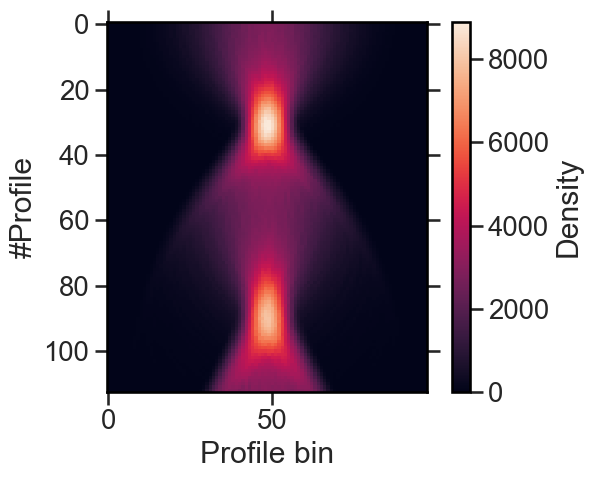

In [44]:
measured_waterfall = frames.to_waterfall(np.array(raw_data, dtype=float).flatten())

plt.imshow(measured_waterfall)
plt.xlabel('Profile bin')
plt.ylabel('#Profile')
plt.colorbar(label='Density');

<h4>Settings</h4>

Reconstruction will be carried out at the following profile index:
(choose `0` for the first profile, or `-2` for the last, or any number < `len(measured_waterfall) - 1`)

In [45]:
reconstr_idx = 0

Number of iterations of ART:

In [46]:
niterations = 10

<h4>Projection Matrix</h4>

Establishing the map via tracking (nonlinear synchrotron motion), i.e. matrix $A$:

In [47]:
tracker = tracking.Tracking(mach)

phip, dEp = tracker.track(reconstr_idx)

In [48]:
# Converting from physical coordinates ([rad], [eV])
# to internal phase space coordinates.
if not tracker.self_field_flag:
    phip, dEp = particles.physical_to_coords(
        phip, dEp, mach, tracker.particles.xorigin,
        tracker.particles.dEbin)

In [49]:
phip, dEp = particles.ready_for_tomography(phip, dEp, mach.nbins)

profiles = tomoin.raw_data_to_profiles(
    measured_waterfall, mach, frames.rebin, frames.sampling_time)
profiles.calc_profilecharge()

waterfall = profiles.waterfall

In [50]:
# further preparations
nprofs = waterfall.shape[0]
nbins = waterfall.shape[1]
nparts = phip.shape[0]

flat_profs = waterfall.copy()
flat_profs = flat_profs.clip(0.0)

flat_profs /= np.sum(flat_profs, axis=1)[:, None]
flat_profs = np.ascontiguousarray(flat_profs.flatten()).astype(float)

waterfall /= np.sum(waterfall, axis=1)[:, None]

flat_points = phip.copy()
for i in range(nprofs):
    flat_points[:, i] += nbins * i

Starting the algebraic reconstruction technique (ART) algorithm:

In [51]:
# Initialising arrays with zeros
weight = np.zeros(nparts)
rec_wf = np.zeros(waterfall.shape)

In [52]:
# Initial estimation of weight factors using (flattened) measured profiles.
weight = tmo.libtomo.back_project(weight, flat_points, flat_profs,
                                  nparts, nprofs)
weight = weight.clip(0.0)

In [53]:
diff = []
for i in range(niterations):
    # Projection from phase space to time projections
    rec_wf = tmo.libtomo.project(rec_wf, flat_points, weight, nparts,
                                 nprofs, nbins)

    # Normalizing reconstructed waterfall
    rec_wf /= np.sum(rec_wf, axis=1)[:, None]

    # Finding difference between measured and reconstructed waterfall
    dwaterfall = waterfall - rec_wf

    # Setting to zero for next round
    rec_wf[:] = 0.0

    # Calculating discrepancy
    diff.append(np.sqrt(np.sum(dwaterfall**2) / (nbins * nprofs)))

    # Back projection using the difference between measured and recorded waterfall
    weight = tmo.libtomo.back_project(weight, flat_points, dwaterfall.flatten(),
                                      nparts, nprofs)
    # non-linearity of ART:
    weight = weight.clip(0.0)

    print(f'Iteration: {i:3d}, discrepancy: {diff[-1]:3e}')

Iteration:   0, discrepancy: 9.043262e-03
Iteration:   1, discrepancy: 7.403652e-03
Iteration:   2, discrepancy: 6.275827e-03
Iteration:   3, discrepancy: 5.433833e-03
Iteration:   4, discrepancy: 4.773068e-03
Iteration:   5, discrepancy: 4.241804e-03
Iteration:   6, discrepancy: 3.804729e-03
Iteration:   7, discrepancy: 3.437714e-03
Iteration:   8, discrepancy: 3.124893e-03
Iteration:   9, discrepancy: 2.854680e-03


In [54]:
# Finding last discrepancy...
rec_wf = tmo.libtomo.project(rec_wf, flat_points, weight, nparts, nprofs, nbins)
rec_wf /= np.sum(rec_wf, axis=1)[:, None]
dwaterfall = waterfall - rec_wf
diff.append(np.sqrt(np.sum(dwaterfall**2) / (nbins * nprofs)))

print(f'Iteration: {i + 1:3d}, discrepancy: {diff[-1]:3E}')

Iteration:  10, discrepancy: 2.618902E-03


Reconstruction finished, return the reconstructed phase-space distribution:

In [55]:
phasespace = tomoout.create_phase_space_image(
    phip, dEp, weight, nbins, reconstr_idx)

<h4>Results from Tomography</h4>

The profile of the reconstructed distribution compared to the input profile:

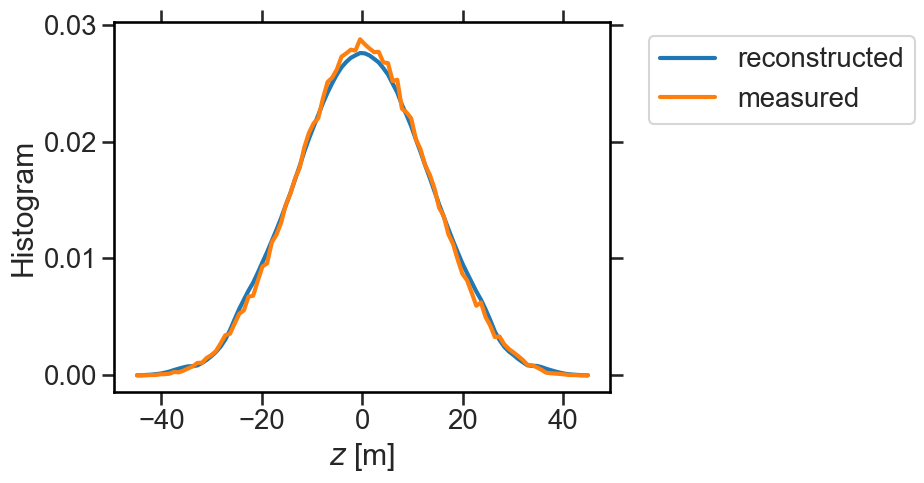

In [56]:
prof_rec = np.sum(phasespace, axis=1)
z_rec = (0.5 + np.arange(-len(prof_rec)/2, len(prof_rec)/2)) * (-dtbin * beta * c)

plt.plot(z_rec, prof_rec, label='reconstructed')
plt.plot(z_rec, waterfall[reconstr_idx], label='measured')

plt.xlabel('$z$ [m]')
plt.ylabel('Histogram')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

The reconstructed rms bunch length is: $\sigma_z = \sqrt{\cfrac{\sum_i p(z_i) \cdot (z_i - \langle z \rangle)^2}{\sum_i p(z_i)}}$

In [57]:
np.sqrt(np.trapz(prof_rec * z_rec**2, z_rec) / np.trapz(prof_rec, z_rec))

13.026037492413336

The original macro-particle distribution was generated with:

In [58]:
sigma_z

12.769476658495181

The momentum distribution of the reconstructed distribution:

In [59]:
Etot = Ekin + m_p/e * c**2 # in eV

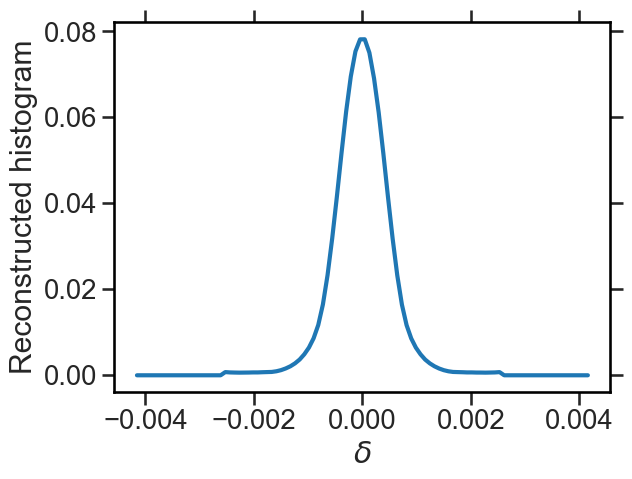

In [60]:
profdp_rec = np.sum(phasespace, axis=0)
dp_rec = (0.5 + np.arange(-len(profdp_rec)/2, len(profdp_rec)/2)) * (tracker.particles.dEbin / (Etot) * beta**2)

plt.plot(dp_rec, profdp_rec)
plt.xlabel('$\delta$')
plt.ylabel('Reconstructed histogram');

The reconstructed rms momentum deviation is: $\sigma_\delta = \sqrt{\cfrac{\sum_i p(\delta_i) \cdot (\delta_i - \langle \delta \rangle)^2}{\sum_i p(\delta_i)}}$

In [61]:
np.sqrt(np.trapz(profdp_rec * dp_rec**2, dp_rec) / np.trapz(profdp_rec, dp_rec))

0.0005217091822349119

Here is the full reconstructed phase-space distribution:

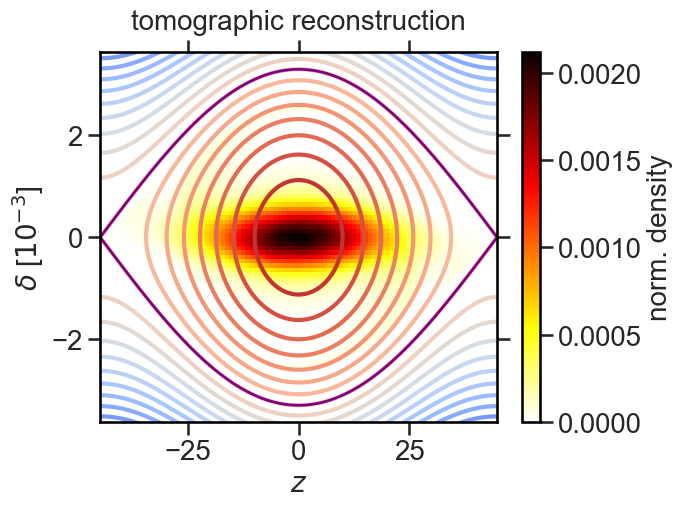

In [62]:
plot_tomo(phasespace, z_rec, dp_rec, rfb);

$\implies$ Does this fit the initial macro-particle distribution?

$\implies$ Re-run the tomographic reconstruction for the last profile (see settings part above, start from section B.)! Does it match the final macro-particle distribution?

The final macro-particle phase-space distribution after the simulation:

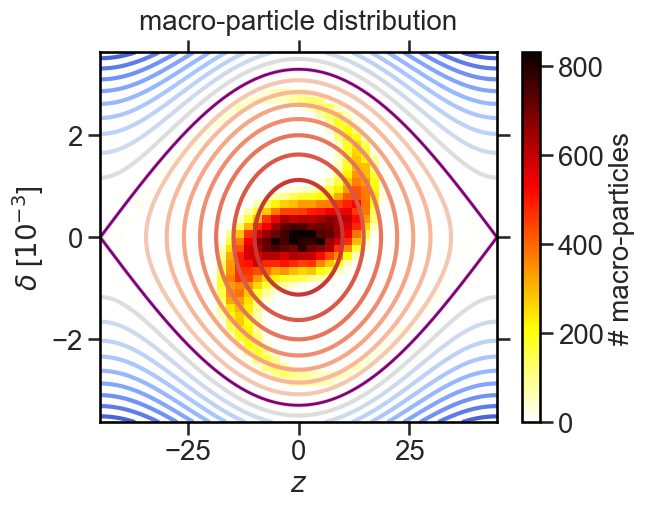

In [63]:
plot_mp(z, dp, rfb);

In [64]:
!pip show longitudinal_tomography

Name: longitudinal_tomography
Version: 3.5.1
Summary: A python library for longitudinal particle beam tomography
Home-page: https://gitlab.cern.ch/longitudinaltomography/tomographyv3
Author: Christoffer Hjertø Grindheim
Author-email: Simon Albright <simon.albright@cern.ch>, Bernardo Abreu Figueiredo <bernardo.abreu.figueiredo@cern.ch>, Anton Lu <anton.lu@cern.ch>
License: GNU General Public License version 3
Location: /Users/thiloegenolf/Downloads/testpython311/lib/python3.11/site-packages
Requires: matplotlib, multipledispatch, numpy, scipy
Required-by: 


In [65]:
t

NameError: name 't' is not defined